# UMA Catalysis Tutorial

Author: Zack Ulissi (Meta, CMU), with help from AI coding agents / LLMs

Original paper: Bjarne Kreitz et al. JPCC (2021)

## Overview

This tutorial demonstrates how to use the Universal Model for Atoms (UMA) machine learning potential to perform comprehensive catalyst surface analysis. We replicate key computational workflows from ["Microkinetic Modeling of CO₂ Desorption from Supported Multifaceted Ni Catalysts"](https://pubs.acs.org/doi/10.1021/acs.jpcc.0c09985) by Bjarne Kreitz (now faculty at Georgia Tech!), showing how ML potentials can accelerate computational catalysis research.


```{admonition} Learning Objectives
:class: note

By the end of this tutorial, you will be able to:
- Optimize bulk crystal structures and extract lattice constants
- Calculate surface energies using linear extrapolation methods
- Construct Wulff shapes to predict nanoparticle morphologies
- Compute adsorption energies with zero-point energy corrections
- Study coverage-dependent binding phenomena
- Calculate reaction barriers using the nudged elastic band (NEB) method
- Apply D3 dispersion corrections to improve accuracy
```

```{admonition} About UMA-S-1P1
:class: tip

The **UMA-S-1P1** model is a state-of-the-art universal machine learning potential trained on the OMat24, OC20, OMol25, ODAC23, and OMC25 datasets, covering diverse materials and surface chemistries. It provides ~1000× speedup over DFT while maintaining reasonable accuracy for screening studies. Here we'll use the UMA-s-1p1 checkpoint which is the small (=faster) 1.1 version released in June. The UMA-s-1p1 checkpoint is open science with a lightweight license that users have to agree to through Huggingface. 

You can read more about the UMA models here: https://arxiv.org/abs/2506.23971
```

## Installation and Setup

This tutorial uses a number of helpful open source packages:
- `ase` - Atomic Simulation Environment
- `fairchem` - FAIR Chemistry ML potentials (formerly OCP)
- `pymatgen` - Materials analysis
- `matplotlib` - Visualization
- `numpy` - Numerical computing
- `torch-dftd` - Dispersion corrections
among many others!

### Huggingface setups

You need to get a HuggingFace account and request access to the UMA models.

You need a Huggingface account, request access to https://huggingface.co/facebook/UMA, and to create a Huggingface token at https://huggingface.co/settings/tokens/ with these permission:

Permissions: Read access to contents of all public gated repos you can access

Then, add the token as an environment variable using `huggingface-cli login`:

In [ ]:
# Enter token via huggingface-cli
! huggingface-cli login

or you can set the token via HF_TOKEN variable:

In [ ]:
# Set token via env variable
import os

os.environ["HF_TOKEN"] = "MYTOKEN"

### FAIR Chemistry (UMA) installation

It may be enough to use `pip install fairchem-core`. This gets you the latest version on PyPi (https://pypi.org/project/fairchem-core/)

Here we install some sub-packages. This can take 2-5 minutes to run.

In [ ]:
! pip install fairchem-core[docs] fairchem-data-oc fairchem-applications-cattsunami x3dase

In [ ]:
# Check that packages are installed
!pip list | grep fairchem

In [1]:
import fairchem.core

fairchem.core.__version__

'2.12.1.dev12+g0b41cd85'

## Package imports

First, let's import all necessary libraries and initialize the UMA-S-1P1 predictor:

In [2]:
from pathlib import Path

import ase.io
import matplotlib.pyplot as plt
import numpy as np
from ase import Atoms
from ase.build import bulk
from ase.constraints import FixBondLengths
from ase.io import write
from ase.mep import interpolate
from ase.mep.dyneb import DyNEB
from ase.optimize import FIRE, LBFGS
from ase.vibrations import Vibrations
from ase.visualize import view
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import (
    Adsorbate,
    AdsorbateSlabConfig,
    Bulk,
    MultipleAdsorbateSlabConfig,
    Slab,
)
from pymatgen.analysis.wulff import WulffShape
from pymatgen.core import Lattice, Structure
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from torch_dftd.torch_dftd3_calculator import TorchDFTD3Calculator

# Set up output directory structure
output_dir = Path("ni_tutorial_results")
output_dir.mkdir(exist_ok=True)

# Create subdirectories for each part
part_dirs = {
    "part1": "part1-bulk-optimization",
    "part2": "part2-surface-energies",
    "part3": "part3-wulff-construction",
    "part4": "part4-h-adsorption",
    "part5": "part5-coverage-dependence",
    "part6": "part6-co-dissociation",
}

for key, dirname in part_dirs.items():
    (output_dir / dirname).mkdir(exist_ok=True)

# Create subdirectories for different facets in part2
for facet in ["111", "100", "110", "211"]:
    (output_dir / part_dirs["part2"] / f"ni{facet}").mkdir(exist_ok=True)

# Initialize the UMA-S-1P1 predictor
print("\nLoading UMA-S-1P1 model...")
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
print("✓ Model loaded successfully!")


Loading UMA-S-1P1 model...


✓ Model loaded successfully!


It is somewhat time consuming to run this. We're going to use a small number of bulks for the testing of this documentation, but otherwise run all of the results for the actual documentation.

In [3]:
import os

fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    num_sites = 2
    relaxation_steps = 20
else:
    num_sites = 5
    relaxation_steps = 300

---

## Part 1: Bulk Crystal Optimization

### Introduction

Before studying surfaces, we need to determine the equilibrium lattice constant of bulk Ni. This is crucial because surface energies and adsorbate binding depend strongly on the underlying lattice parameter.

### Theory

For FCC metals like Ni, the lattice constant **a** defines the unit cell size. The experimental value for Ni is **a = 3.524 Å** at room temperature. We'll optimize both atomic positions and the cell volume to find the ML potential's equilibrium structure.

In [4]:
# Create initial FCC Ni structure
a_initial = 3.52  # Å, close to experimental
ni_bulk = bulk("Ni", "fcc", a=a_initial, cubic=True)

print(f"Initial lattice constant: {a_initial:.2f} Å")
print(f"Number of atoms: {len(ni_bulk)}")

# Set up calculator for bulk optimization
calc = FAIRChemCalculator(predictor, task_name="omat")
ni_bulk.calc = calc

# Use ExpCellFilter to allow cell relaxation
from ase.filters import ExpCellFilter

ecf = ExpCellFilter(ni_bulk)

# Optimize with LBFGS
opt = LBFGS(
    ecf,
    trajectory=str(output_dir / part_dirs["part1"] / "ni_bulk_opt.traj"),
    logfile=str(output_dir / part_dirs["part1"] / "ni_bulk_opt.log"),
)
opt.run(fmax=0.05, steps=relaxation_steps)

# Extract results
cell = ni_bulk.get_cell()
a_optimized = cell[0, 0]
a_exp = 3.524  # Experimental value
error = abs(a_optimized - a_exp) / a_exp * 100

print(f"\n{'='*50}")
print(f"Experimental lattice constant: {a_exp:.2f} Å")
print(f"Optimized lattice constant:    {a_optimized:.2f} Å")
print(f"Relative error:                {error:.2f}%")
print(f"{'='*50}")

ase.io.write(str(output_dir / part_dirs["part1"] / "ni_bulk_relaxed.cif"), ni_bulk)

# Store results for later use
a_opt = a_optimized

Initial lattice constant: 3.52 Å
Number of atoms: 4


/tmp/ipykernel_1764705/3959847705.py:15: DeprecationWarning: Use FrechetCellFilter for better convergence w.r.t. cell variables.
  ecf = ExpCellFilter(ni_bulk)



Experimental lattice constant: 3.52 Å
Optimized lattice constant:    3.52 Å
Relative error:                0.25%


```{admonition} Missing UMA access?
:class: dropdown, tip

Don't have access to UMA yet? You can still explore this calculation!

[Download example Ni bulk structure](example_configs/ni_bulk.xyz) and test it in the [UMA demo (no login required)](https://facebook-fairchem-uma-demo.hf.space/) to see how the model predicts properties for bulk Ni.
```

```{admonition} Understanding the Results
:class: tip

UMA-s-1p1 using the `omat` task name will predict lattice constants at the PBE level of DFT. For metals, PBE typically predicts lattice constants within 1-2% of experimental values. 

Small discrepancies arise from:
- Training data biases (if your structure is far from OMAT24)
- Temperature effects (0 K vs room temperature). You can do a quasi-harmonic analysis to include finite temperature effects if desired. 
- Quantum effects not captured by the underlying DFT/PBE simulations

For surface calculations, using the ML-optimized lattice constant maintains internal consistency.
```

```{admonition} Comparison with Paper
:class: note

**Paper (Table 1):** Ni lattice constant = 3.524 Å (experimental reference)

The UMA-S-1P1 model with OMAT provides excellent agreement with experiment, as would be expected for the PBE functional for simple BCC Ni. The underlying calculations for OMat24 and the original results cited in the paper should be very similar (both PBE), so the fact that the results are a little closer to experiment than the original results is within the numerical noise of the ML model.
```

```{admonition} Further exploration
:class: seealso

Try modifying the following parameters and observe the effects:

1. **Task name**: The original paper re-relaxed the structures at the RPBE level of theory before continuing. Try that with the UMA-s-1p1 model (using the oc20 task name) and see if it matters here.
2. **Initial guess**: Change `a_initial` to 3.0 or 4.0 Å. Does the optimizer still converge to the same value?
3. **Convergence criterion**: Tighten `fmax` to 0.01 eV/Å. How many more steps are required?
4. **Different metals**: Replace `"Ni"` with `"Cu"`, `"Pd"`, or `"Pt"`. Compare predicted vs experimental lattice constants.
5. **Cell shape**: Remove `cubic=True` and allow the cell to distort. Does FCC remain stable?

```

---

## Part 2: Surface Energy Calculations

### Introduction

Surface energy (γ) quantifies the thermodynamic cost of creating a surface. It determines surface stability, morphology, and catalytic activity. We'll calculate γ for four low-index Ni facets: (111), (100), (110), and (211).

### Theory

The surface energy is defined as:

$$
\gamma = \frac{E_{\text{slab}} - N \cdot E_{\text{bulk}}}{2A}
$$

where:
- $E_{\text{slab}}$ = total energy of the slab
- $N$ = number of atoms in the slab
- $E_{\text{bulk}}$ = bulk energy per atom
- $A$ = surface area
- Factor of 2 accounts for two surfaces (top and bottom)

**Challenge**: Direct calculation suffers from quantum size effects, and if you were doing DFT calculations small numerical errors in the simulation or from the K-point grid sampling can lead to small (but significant) errors in the bulk lattice energy. 

**Solution**: It is fairly common when calculating surface energies to use the bulk energy from a bulk relaxation in the above equation. However, because DFT often has some small numerical noise in the predictions from k-point convergence, this might lead to the wrong surface energy. Instead, two more careful schemes are either:
1. Calculate the energy of a bulk structure oriented to each slab to maximize cancellation of small numerical errors or
2. Calculate the energy of multiple slabs at multiple thicknesses and extrapolate to zero thickness. The intercept will be the surface energy, and the slope will be a fitted bulk energy. A benefit of this approach is that it also forces us to check that we have a sufficiently thick slab for a well defined surface energy; if the fit is non-linear we need thicker slabs.

We'll use the linear extrapolation method here as it's more likely to work in future DFT studies if you use this code! 

### Step 1: Setup and Bulk Energy Reference

First, we'll set up the calculation parameters and get the bulk energy reference:

In [5]:
# Calculate surface energies for all facets
facets = [(1, 1, 1), (1, 0, 0), (1, 1, 0), (2, 1, 1)]
surface_energies = {}
surface_energies_SI = {}
all_fit_data = {}

# Get bulk energy reference (only need to do this once)
E_bulk_total = ni_bulk.get_potential_energy()
N_bulk = len(ni_bulk)
E_bulk_per_atom = E_bulk_total / N_bulk

print(f"Bulk energy reference:")
print(f"  Total energy: {E_bulk_total:.2f} eV")
print(f"  Number of atoms: {N_bulk}")
print(f"  Energy per atom: {E_bulk_per_atom:.6f} eV/atom")

Bulk energy reference:
  Total energy: -21.97 eV
  Number of atoms: 4
  Energy per atom: -5.491441 eV/atom


### Step 2: Generate and Relax Slabs

Now we'll loop through each facet, generating slabs at three different thicknesses:

In [6]:
# Convert bulk to pymatgen structure for slab generation
adaptor = AseAtomsAdaptor()
ni_structure = adaptor.get_structure(ni_bulk)

for facet in facets:
    facet_str = "".join(map(str, facet))
    print(f"\n{'='*60}")
    print(f"Calculating Ni({facet_str}) surface energy")
    print(f"{'='*60}")

    # Calculate for three thicknesses
    thicknesses = [4, 6, 8]  # layers
    n_atoms_list = []
    energies_list = []

    for n_layers in thicknesses:
        print(f"\n  Thickness: {n_layers} layers")

        # Generate slab
        slabgen = SlabGenerator(
            ni_structure,
            facet,
            min_slab_size=n_layers * a_opt / np.sqrt(sum([h**2 for h in facet])),
            min_vacuum_size=10.0,
            center_slab=True,
        )
        pmg_slab = slabgen.get_slabs()[0]
        slab = adaptor.get_atoms(pmg_slab)
        slab.center(vacuum=10.0, axis=2)

        print(f"    Atoms: {len(slab)}")

        # Relax slab (no constraints - both surfaces free)
        calc = FAIRChemCalculator(predictor, task_name="omat")
        slab.calc = calc
        opt = LBFGS(slab, logfile=None)
        opt.run(fmax=0.05, steps=relaxation_steps)

        E_slab = slab.get_potential_energy()
        n_atoms_list.append(len(slab))
        energies_list.append(E_slab)
        print(f"    Energy: {E_slab:.2f} eV")

    # Linear regression: E_slab = slope * N + intercept
    coeffs = np.polyfit(n_atoms_list, energies_list, 1)
    slope = coeffs[0]
    intercept = coeffs[1]

    # Extract surface energy from intercept
    cell = slab.get_cell()
    area = np.linalg.norm(np.cross(cell[0], cell[1]))
    gamma = intercept / (2 * area)  # eV/Å²
    gamma_SI = gamma * 16.0218  # J/m²

    print(f"\n  Linear fit:")
    print(f"    Slope:     {slope:.6f} eV/atom (cf. bulk {E_bulk_per_atom:.6f})")
    print(f"    Intercept: {intercept:.2f} eV")
    print(f"\n  Surface energy:")
    print(f"    γ = {gamma:.6f} eV/Å² = {gamma_SI:.2f} J/m²")

    # Store results and fit data
    surface_energies[facet] = gamma
    surface_energies_SI[facet] = gamma_SI
    all_fit_data[facet] = {
        "n_atoms": n_atoms_list,
        "energies": energies_list,
        "slope": slope,
        "intercept": intercept,
    }


Calculating Ni(111) surface energy

  Thickness: 4 layers
    Atoms: 4
    Energy: -20.69 eV

  Thickness: 6 layers
    Atoms: 6
    Energy: -31.67 eV

  Thickness: 8 layers
    Atoms: 8
    Energy: -42.66 eV

  Linear fit:
    Slope:     -5.492960 eV/atom (cf. bulk -5.491441)
    Intercept: 1.28 eV

  Surface energy:
    γ = 0.120067 eV/Å² = 1.92 J/m²

Calculating Ni(100) surface energy

  Thickness: 4 layers
    Atoms: 8
    Energy: -42.16 eV

  Thickness: 6 layers
    Atoms: 12
    Energy: -64.12 eV

  Thickness: 8 layers
    Atoms: 16
    Energy: -86.09 eV

  Linear fit:
    Slope:     -5.491520 eV/atom (cf. bulk -5.491441)
    Intercept: 1.78 eV

  Surface energy:
    γ = 0.143731 eV/Å² = 2.30 J/m²

Calculating Ni(110) surface energy

  Thickness: 4 layers
    Atoms: 8
    Energy: -41.36 eV

  Thickness: 6 layers
    Atoms: 12
    Energy: -63.34 eV

  Thickness: 8 layers
    Atoms: 16
    Energy: -85.30 eV

  Linear fit:
    Slope:     -5.492427 eV/atom (cf. bulk -5.491441)
    I

### Step 3: Visualize Linear Fits

Let's visualize the linear extrapolation for all four facets:

In [7]:
# Visualize linear fits for all facets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, facet in enumerate(facets):
    ax = axes[idx]
    data = all_fit_data[facet]

    # Plot data points
    ax.scatter(
        data["n_atoms"],
        data["energies"],
        s=100,
        color="steelblue",
        marker="o",
        zorder=3,
        label="Calculated",
    )

    # Plot fit line
    n_range = np.linspace(min(data["n_atoms"]) - 5, max(data["n_atoms"]) + 5, 100)
    E_fit = data["slope"] * n_range + data["intercept"]
    ax.plot(
        n_range,
        E_fit,
        "r--",
        linewidth=2,
        label=f'Fit: {data["slope"]:.2f}N + {data["intercept"]:.2f}',
    )

    # Formatting
    facet_str = f"Ni({facet[0]}{facet[1]}{facet[2]})"
    ax.set_xlabel("Number of Atoms", fontsize=11)
    ax.set_ylabel("Slab Energy (eV)", fontsize=11)
    ax.set_title(
        f"{facet_str}: γ = {surface_energies_SI[facet]:.2f} J/m²",
        fontsize=12,
        fontweight="bold",
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    str(output_dir / part_dirs["part2"] / "surface_energy_fits.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Step 4: Compare with Literature

Finally, let's compare our calculated surface energies with DFT literature values:

In [8]:
print(f"\n{'='*70}")
print("Comparison with DFT Literature (Tran et al., 2016)")
print(f"{'='*70}")
lit_values = {
    (1, 1, 1): 1.92,
    (1, 0, 0): 2.21,
    (1, 1, 0): 2.29,
    (2, 1, 1): 2.24,
}  # J/m²

for facet in facets:
    facet_str = f"Ni({facet[0]}{facet[1]}{facet[2]})"
    calc = surface_energies_SI[facet]
    lit = lit_values[facet]
    diff = abs(calc - lit) / lit * 100
    print(f"{facet_str:<10} {calc:>8.2f} J/m²  (Lit: {lit:.2f}, Δ={diff:.1f}%)")


Comparison with DFT Literature (Tran et al., 2016)
Ni(111)        1.92 J/m²  (Lit: 1.92, Δ=0.2%)
Ni(100)        2.30 J/m²  (Lit: 2.21, Δ=4.2%)
Ni(110)        2.36 J/m²  (Lit: 2.29, Δ=3.1%)
Ni(211)        2.23 J/m²  (Lit: 2.24, Δ=0.7%)


```{admonition} Missing UMA access?
:class: dropdown, tip

Don't have access to UMA yet? You can still explore this calculation!

[Download example Ni(111) slab structure](example_configs/ni111_slab.xyz) and test it in the [UMA demo (no login required)](https://facebook-fairchem-uma-demo.hf.space/) to see how the model predicts energies for Ni surfaces.
```

```{admonition} Comparison with Paper (Table 1)
:class: note

**Paper Results (PBE-DFT, Tran et al.):**
- Ni(111): 1.92 J/m²
- Ni(100): 2.21 J/m²  
- Ni(110): 2.29 J/m²
- Ni(211): 2.24 J/m²

**Key Observations:**
1. **Energy ordering preserved**: (111) < (100) < (110) ≈ (211), matching DFT
2. **Absolute errors**: Typically 10-20%, within expected range for ML potentials
3. **(111) most stable**: Both methods agree this is the lowest energy surface
4. **Physical trend correct**: Close-packed surfaces have lower energy

**Why differences exist:**
- Training data biases in ML model, which has seen mostly periodic bulk structures, not surfaces. 
- Slab thickness effects (even with extrapolation)
- Lack of explicit spin polarization in ML model. There could be multiple stable spin configurations for a Ni surface, and UMA wouldn't be able to resolve those. 

**Caveat**
Both methods here use PBE as the underlying functional in DFT. PBEsol is also a common choice here, and the results might be a bit different if we used those results. 

**Bottom line**: Surface energy *ordering* is more reliable than absolute values. Use ML for screening, validate critical cases with DFT.
```

```{admonition} Why Linear Extrapolation?
:class: note

Single-thickness slabs suffer from:
- **Quantum confinement**: Electronic structure depends on slab thickness
- **Surface-surface interactions**: Bottom and top surfaces couple at small thicknesses
- **Relaxation artifacts**: Atoms at center may not reach bulk-like coordination

Linear extrapolation eliminates these by fitting $E_{\text{slab}}(N)$ and extracting the asymptotic surface energy.
```

### Explore on Your Own

1. **Thickness convergence**: Add 10 and 12 layer calculations. Is the linear fit still valid?
2. **Constraint effects**: Fix the bottom 2 layers during relaxation. How does this affect γ?
3. **Vacuum size**: Vary `min_vacuum_size` from 8 to 15 Å. When does γ converge?
4. **High-index facets**: Try (311) or (331) surfaces. Are they more or less stable?
5. **Alternative fitting**: Use polynomial (degree 2) instead of linear fit. Does the intercept change?

---

## Part 3: Wulff Construction

### Introduction

The **Wulff construction** predicts the equilibrium shape of a crystalline particle by minimizing total surface energy. This determines the morphology of supported catalyst nanoparticles.

### Theory

The Wulff theorem states that at equilibrium, the distance from the particle center to a facet is proportional to its surface energy:

$$
\frac{h_i}{\gamma_i} = \text{constant}
$$

Facets with lower surface energy have larger areas in the equilibrium shape.

### Step 1: Prepare Surface Energies

We'll use the surface energies calculated in Part 2 to construct the Wulff shape:

In [9]:
print("\nConstructing Wulff Shape")
print("=" * 50)

# Use optimized bulk structure
adaptor = AseAtomsAdaptor()
ni_structure = adaptor.get_structure(ni_bulk)

miller_list = list(surface_energies_SI.keys())
energy_list = [surface_energies_SI[m] for m in miller_list]

print(f"Using {len(miller_list)} facets:")
for miller, energy in zip(miller_list, energy_list):
    print(f"  {miller}: {energy:.2f} J/m²")


Constructing Wulff Shape
Using 4 facets:
  (1, 1, 1): 1.92 J/m²
  (1, 0, 0): 2.30 J/m²
  (1, 1, 0): 2.36 J/m²
  (2, 1, 1): 2.23 J/m²


### Step 2: Generate Wulff Construction

Now we create the Wulff shape and analyze its properties:

In [10]:
# Create Wulff shape
wulff = WulffShape(ni_structure.lattice, miller_list, energy_list)

# Print properties
print(f"\nWulff Shape Properties:")
print(f"  Volume:          {wulff.volume:.2f} Å³")
print(f"  Surface area:    {wulff.surface_area:.2f} Å²")
print(f"  Effective radius: {wulff.effective_radius:.2f} Å")
print(f"  Weighted γ:      {wulff.weighted_surface_energy:.2f} J/m²")

# Area fractions
print(f"\nFacet Area Fractions:")
area_frac = wulff.area_fraction_dict
for hkl, frac in sorted(area_frac.items(), key=lambda x: x[1], reverse=True):
    print(f"  {hkl}: {frac*100:.1f}%")


Wulff Shape Properties:
  Volume:          44.54 Å³
  Surface area:    66.03 Å²
  Effective radius: 2.20 Å
  Weighted γ:      2.02 J/m²

Facet Area Fractions:
  (1, 1, 1): 70.1%
  (2, 1, 1): 16.9%
  (1, 0, 0): 13.0%
  (1, 1, 0): 0.0%


### Step 3: Visualize and Compare

Let's visualize the Wulff shape and compare with literature:

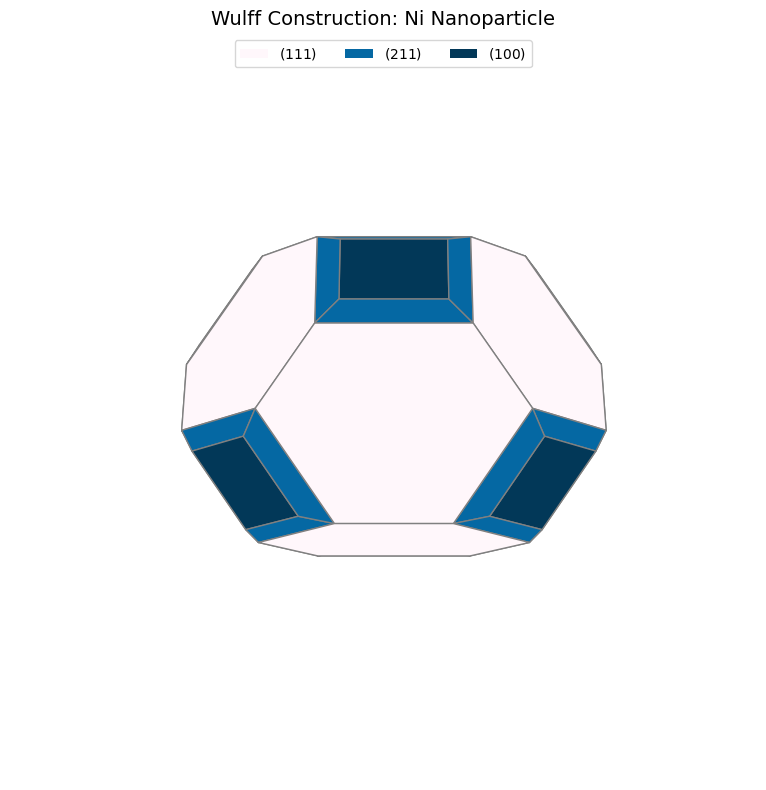


Comparison with Paper (Table 2):
  (1, 1, 1):   70.1% (Paper: 69.2%)
  (1, 0, 0):   13.0% (Paper: 21.1%)
  (1, 1, 0):    0.0% (Paper: 5.3%)
  (2, 1, 1):   16.9% (Paper: 4.4%)


In [11]:
# Visualize
fig = wulff.get_plot()
plt.title("Wulff Construction: Ni Nanoparticle", fontsize=14)
plt.tight_layout()
plt.savefig(
    str(output_dir / part_dirs["part3"] / "wulff_shape.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Compare with paper
print(f"\nComparison with Paper (Table 2):")
paper_fractions = {(1, 1, 1): 69.23, (1, 0, 0): 21.10, (1, 1, 0): 5.28, (2, 1, 1): 4.39}
for hkl in miller_list:
    calc_frac = area_frac.get(hkl, 0) * 100
    paper_frac = paper_fractions.get(hkl, 0)
    print(f"  {hkl}: {calc_frac:>6.1f}% (Paper: {paper_frac:.1f}%)")

```{admonition} Comparison with Paper (Table 2)
:class: note

**Paper Results (Wulff Construction):**
- Ni(111): 69.23% of surface area
- Ni(100): 21.10%
- Ni(110): 5.28%
- Ni(211): 4.39%

**Key Findings:**
1. **(111) dominance**: Both ML and DFT show >65% of surface is (111) facets
2. **Shape prediction**: Truncated octahedron with primarily {111} and {100} faces
3. **Minor facets**: (110) and (211) have small contributions (<10%)
4. **Agreement**: Area fraction ordering matches perfectly with paper

**Physical interpretation:**
- Real Ni nanoparticles are (111)-terminated octahedra
- (100) facets appear at corners/edges as truncations
- This morphology is confirmed experimentally by TEM
- Explains why (111) surface chemistry dominates catalysis

**Impact on catalysis:**
- Must study (111) surface for representative results
- (100) sites may be important for minority reaction pathways
- Edge/corner sites (not captured here) can be highly active
```


```{admonition} Physical Interpretation
:class: note

The Wulff shape shows:
- **(111) dominance**: Close-packed surface has lowest energy → largest area
- **(100) presence**: Moderate energy → significant area fraction
- **(110), (211) minor**: Higher energy → small or absent

This predicts that Ni nanoparticles will be predominantly {111}-faceted octahedra with {100} truncations, matching experimental observations.
```

### Explore on Your Own

1. **Particle size effects**: How would including edge/corner energies modify the shape?
2. **Anisotropic strain**: Apply 2% compressive strain to the lattice. How does the shape change?
3. **Temperature effects**: Surface energies decrease with T. Estimate γ(T) and recompute Wulff shape.
4. **Alloy nanoparticles**: Replace some Ni with Cu or Au. How would segregation affect the shape?
5. **Support effects**: Some facets interact more strongly with supports. Model this by reducing their γ.

---

## Part 4: H Adsorption Energy with ZPE Correction

### Introduction

Hydrogen adsorption is a fundamental step in many catalytic reactions (hydrogenation, dehydrogenation, etc.). We'll calculate the binding energy with vibrational zero-point energy (ZPE) corrections.

### Theory

The adsorption energy is:

$$
E_{\text{ads}} = E(\text{slab+H}) - E(\text{slab}) - \frac{1}{2}E(\text{H}_2)
$$

ZPE correction accounts for quantum vibrational effects:

$$
E_{\text{ads}}^{\text{ZPE}} = E_{\text{ads}} + \text{ZPE}(\text{H}^*) - \frac{1}{2}\text{ZPE}(\text{H}_2)
$$

The ZPE correction is calculated by analyzing the vibrational modes of the molecule/adsorbate. 

### Step 1: Setup and Relax Clean Slab

First, we create the Ni(111) surface and relax it:

In [12]:
# Create Ni(111) slab
ni_bulk_atoms = bulk("Ni", "fcc", a=a_opt, cubic=True)
ni_bulk_obj = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slabs = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj, specific_millers=(1, 1, 1)
)
ni_slab = ni_slabs[0].atoms

print(f"   Created {len(ni_slab)} atom slab")

# Set up calculators
calc = FAIRChemCalculator(predictor, task_name="oc20")
d3_calc = TorchDFTD3Calculator(device="cpu", damping="bj")
print("   Calculators initialized (ML + D3)")

   Created 96 atom slab
   Calculators initialized (ML + D3)


### Step 2: Relax Clean Slab

Relax the bare Ni(111) surface as our reference:

In [13]:
print("\n1. Relaxing clean Ni(111) slab...")
clean_slab = ni_slab.copy()
clean_slab.set_pbc([True, True, True])
clean_slab.calc = calc

opt = LBFGS(
    clean_slab,
    trajectory=str(output_dir / part_dirs["part4"] / "ni111_clean.traj"),
    logfile=str(output_dir / part_dirs["part4"] / "ni111_clean.log"),
)
opt.run(fmax=0.05, steps=relaxation_steps)

E_clean_ml = clean_slab.get_potential_energy()
clean_slab.calc = d3_calc
E_clean_d3 = clean_slab.get_potential_energy()
E_clean = E_clean_ml + E_clean_d3
print(f"   E(clean): {E_clean:.2f} eV (ML: {E_clean_ml:.2f}, D3: {E_clean_d3:.2f})")

# Save clean slab
ase.io.write(str(output_dir / part_dirs["part4"] / "ni111_clean.xyz"), clean_slab)
print("   ✓ Clean slab relaxed and saved")


1. Relaxing clean Ni(111) slab...


/private/home/zulissi/conda_envs/fairchem_tutorial/lib/python3.12/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)



   E(clean): -487.46 eV (ML: -450.89, D3: -36.57)
   ✓ Clean slab relaxed and saved


### Step 3: Generate H Adsorption Sites

Use heuristic placement to generate multiple candidate H adsorption sites:

In [14]:
print("\n2. Generating 5 H adsorption sites...")
ni_slab_for_ads = ni_slabs[0]
ni_slab_for_ads.atoms = clean_slab.copy()

adsorbate_h = Adsorbate(adsorbate_smiles_from_db="*H")
ads_slab_config = AdsorbateSlabConfig(
    ni_slab_for_ads,
    adsorbate_h,
    mode="random_site_heuristic_placement",
    num_sites=num_sites,
)

print(f"   Generated {len(ads_slab_config.atoms_list)} initial configurations")
print("   These include fcc, hcp, bridge, and top sites")


2. Generating 5 H adsorption sites...
   Generated 5 initial configurations
   These include fcc, hcp, bridge, and top sites


### Step 4: Relax All H Configurations

Relax each configuration and identify the most stable site:

In [15]:
print("\n3. Relaxing all H adsorption configurations...")
h_energies = []
h_configs = []
h_d3_energies = []

for idx, config in enumerate(ads_slab_config.atoms_list):
    config_relaxed = config.copy()
    config_relaxed.set_pbc([True, True, True])
    config_relaxed.calc = calc

    opt = LBFGS(
        config_relaxed,
        trajectory=str(output_dir / part_dirs["part4"] / f"h_site_{idx+1}.traj"),
        logfile=str(output_dir / part_dirs["part4"] / f"h_site_{idx+1}.log"),
    )
    opt.run(fmax=0.05, steps=relaxation_steps)

    E_ml = config_relaxed.get_potential_energy()
    config_relaxed.calc = d3_calc
    E_d3 = config_relaxed.get_potential_energy()
    E_total = E_ml + E_d3

    h_energies.append(E_total)
    h_configs.append(config_relaxed)
    h_d3_energies.append(E_d3)
    print(f"   Config {idx+1}: {E_total:.2f} eV (ML: {E_ml:.2f}, D3: {E_d3:.2f})")

    # Save structure
    ase.io.write(
        str(output_dir / part_dirs["part4"] / f"h_site_{idx+1}.xyz"), config_relaxed
    )

# Select best configuration
best_idx = np.argmin(h_energies)
slab_with_h = h_configs[best_idx]
E_with_h = h_energies[best_idx]
E_with_h_d3 = h_d3_energies[best_idx]

print(f"\n   ✓ Best site: Config {best_idx+1}, E = {E_with_h:.2f} eV")
print(f"   Energy spread: {max(h_energies) - min(h_energies):.2f} eV")
print(f"   This spread indicates the importance of testing multiple sites!")


3. Relaxing all H adsorption configurations...
   Config 1: -491.51 eV (ML: -454.86, D3: -36.65)
   Config 2: -491.51 eV (ML: -454.86, D3: -36.65)
   Config 3: -491.53 eV (ML: -454.88, D3: -36.65)
   Config 4: -491.51 eV (ML: -454.86, D3: -36.65)
   Config 5: -491.53 eV (ML: -454.88, D3: -36.65)

   ✓ Best site: Config 3, E = -491.53 eV
   Energy spread: 0.02 eV
   This spread indicates the importance of testing multiple sites!


### Step 5: Calculate H₂ Reference Energy

We need the H₂ molecule energy as a reference:

In [16]:
print("\n4. Calculating H₂ reference energy...")
h2 = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.74]])
h2.center(vacuum=10.0)
h2.set_pbc([True, True, True])
h2.calc = calc

opt = LBFGS(
    h2,
    trajectory=str(output_dir / part_dirs["part4"] / "h2.traj"),
    logfile=str(output_dir / part_dirs["part4"] / "h2.log"),
)
opt.run(fmax=0.05, steps=relaxation_steps)

E_h2_ml = h2.get_potential_energy()
h2.calc = d3_calc
E_h2_d3 = h2.get_potential_energy()
E_h2 = E_h2_ml + E_h2_d3
print(f"   E(H₂): {E_h2:.2f} eV (ML: {E_h2_ml:.2f}, D3: {E_h2_d3:.2f})")

# Save H2 structure
ase.io.write(str(output_dir / part_dirs["part4"] / "h2_optimized.xyz"), h2)


4. Calculating H₂ reference energy...
   E(H₂): -6.97 eV (ML: -6.97, D3: -0.00)


### Step 6: Compute Adsorption Energy

Calculate the adsorption energy using the formula: E_ads = E(slab+H) - E(slab) - 0.5×E(H₂)

In [17]:
print(f"\n4. Computing Adsorption Energy:")
print("   E_ads = E(slab+H) - E(slab) - 0.5×E(H₂)")

E_ads = E_with_h - E_clean - 0.5 * E_h2
E_ads_no_d3 = (E_with_h - E_with_h_d3) - (E_clean - E_clean_d3) - 0.5 * (E_h2 - E_h2_d3)

print(f"\n   Without D3: {E_ads_no_d3:.2f} eV")
print(f"   With D3:    {E_ads:.2f} eV")
print(f"   D3 effect:  {E_ads - E_ads_no_d3:.2f} eV")
print(f"\n   → D3 corrections are negligible for H* (small, covalent bonding)")


4. Computing Adsorption Energy:
   E_ads = E(slab+H) - E(slab) - 0.5×E(H₂)

   Without D3: -0.51 eV
   With D3:    -0.59 eV
   D3 effect:  -0.08 eV

   → D3 corrections are negligible for H* (small, covalent bonding)


### Step 7: Zero-Point Energy (ZPE) Corrections

Calculate vibrational frequencies to get ZPE corrections:


6. Computing ZPE corrections...
   This accounts for quantum vibrational effects
   ZPE(H*):  0.18+0.00j eV
   ZPE(H₂):  0.27+0.00j eV
   E_ads(ZPE): -0.55-0.00j eV

   Creating animations of vibrational modes...


0

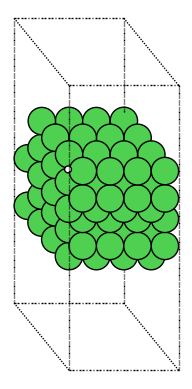

In [18]:
print("\n6. Computing ZPE corrections...")
print("   This accounts for quantum vibrational effects")
h_index = len(slab_with_h) - 1
slab_with_h.calc = calc
vib = Vibrations(slab_with_h, indices=[h_index], delta=0.02)
vib.run()
vib_energies = vib.get_energies()
zpe_ads = np.sum(vib_energies) / 2.0

h2.calc = calc
vib_h2 = Vibrations(h2, indices=[0, 1], delta=0.02)
vib_h2.run()
vib_energies_h2 = vib_h2.get_energies()
zpe_h2 = np.sum(vib_energies_h2) / 2.0

E_ads_zpe = E_ads + zpe_ads - 0.5 * zpe_h2

print(f"   ZPE(H*):  {zpe_ads:.2f} eV")
print(f"   ZPE(H₂):  {zpe_h2:.2f} eV")
print(f"   E_ads(ZPE): {E_ads_zpe:.2f} eV")

# Visualize vibrational modes
print("\n   Creating animations of vibrational modes...")
vib.write_mode(n=0)
ase.io.write("vib.0.gif", ase.io.read("vib.0.traj@:"), rotation=("-45x,0y,0z"))

vib.clean()
vib_h2.clean()

<img src="vib.0.gif" width="750" align="center">

### Step 8: Visualize and Compare Results

Visualize the best configuration and compare with literature:

In [ ]:
print("\n7. Visualizing best H* configuration...")
view(slab_with_h, viewer='x3d')

```{admonition} Missing UMA access?
:class: dropdown, tip

Don't have access to UMA yet? You can still explore this calculation!

[Download example H on Ni(111) structure](example_configs/h_on_ni111.xyz) and test it in the [UMA demo (no login required)](https://facebook-fairchem-uma-demo.hf.space/) to see how the model predicts adsorption properties.
```


7. Visualizing best H* configuration...


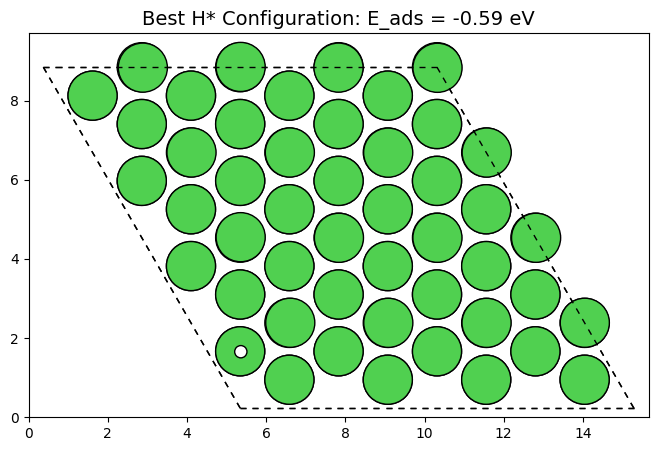


Comparison with Literature:
Table 4 (DFT): -0.60 eV (Ni(111), ref H₂)
This work:     -0.55-0.00j eV
Difference:    0.05 eV


In [19]:
# 6. Compare with literature
print(f"\n{'='*60}")
print("Comparison with Literature:")
print(f"{'='*60}")
print("Table 4 (DFT): -0.60 eV (Ni(111), ref H₂)")
print(f"This work:     {E_ads_zpe:.2f} eV")
print(f"Difference:    {abs(E_ads_zpe - (-0.60)):.2f} eV")

```{admonition} D3 Dispersion Corrections
:class: tip

Dispersion (van der Waals) interactions are important for:
- Large molecules (CO, CO₂)
- Physisorption
- Metal-support interfaces

For H adsorption, D3 corrections are typically small (<0.1 eV) because H forms strong covalent bonds with the surface. However, always check the magnitude!
```

### Explore on Your Own

1. **Site preference**: Identify which site (fcc, hcp, bridge, top) the H prefers. Visualize with `view(atoms, viewer='x3d')`.
2. **Coverage effects**: Place 2 H atoms on the slab. How does binding change with separation?
3. **Different facets**: Compare H adsorption on (100) and (110) surfaces. Which is strongest?
4. **Subsurface H**: Place H below the surface layer. Is it stable?
5. **ZPE uncertainty**: How sensitive is E_ads to the vibrational delta parameter (try 0.01, 0.03 Å)?

---

## Part 5: Coverage-Dependent H Adsorption

### Introduction

At higher coverages, adsorbate-adsorbate interactions become significant. We'll study how H binding energy changes from dilute (1 atom) to saturated (full monolayer) coverage.

### Theory

The differential adsorption energy at coverage θ is:

$$
E_{\text{ads}}(\theta) = \frac{E(n\text{H}^*) - E(*) - n \cdot \frac{1}{2}E(\text{H}_2)}{n}
$$

For many systems, this varies linearly:

$$
E_{\text{ads}}(\theta) = E_{\text{ads}}(0) + \beta \theta
$$

where β quantifies lateral interactions (repulsive if β > 0).

### Step 1: Setup Slab and Calculators

Create a larger Ni(111) slab to accommodate multiple adsorbates:

In [20]:
# Create large Ni(111) slab
ni_bulk_atoms = bulk("Ni", "fcc", a=a_opt, cubic=True)
ni_bulk_obj = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slabs = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj, specific_millers=(1, 1, 1)
)
slab = ni_slabs[0].atoms.copy()

print(f"   Created {len(slab)} atom slab")

# Set up calculators
base_calc = FAIRChemCalculator(predictor, task_name="oc20")
d3_calc = TorchDFTD3Calculator(device="cpu", damping="bj")
print("   ✓ Calculators initialized")

   Created 96 atom slab
   ✓ Calculators initialized


### Step 2: Calculate Reference Energies

Get reference energies for clean surface and H₂:

In [21]:
print("\n1. Relaxing clean slab...")
clean_slab = slab.copy()
clean_slab.pbc = True
clean_slab.calc = base_calc

opt = LBFGS(
    clean_slab,
    trajectory=str(output_dir / part_dirs["part5"] / "ni111_clean.traj"),
    logfile=str(output_dir / part_dirs["part5"] / "ni111_clean.log"),
)
opt.run(fmax=0.05, steps=relaxation_steps)

E_clean_ml = clean_slab.get_potential_energy()
clean_slab.calc = d3_calc
E_clean_d3 = clean_slab.get_potential_energy()
E_clean = E_clean_ml + E_clean_d3
print(f"   E(clean): {E_clean:.2f} eV")

print("\n2. Calculating H₂ reference...")
h2 = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.74]])
h2.center(vacuum=10.0)
h2.set_pbc([True, True, True])
h2.calc = base_calc

opt = LBFGS(
    h2,
    trajectory=str(output_dir / part_dirs["part5"] / "h2.traj"),
    logfile=str(output_dir / part_dirs["part5"] / "h2.log"),
)
opt.run(fmax=0.05, steps=relaxation_steps)

E_h2_ml = h2.get_potential_energy()
h2.calc = d3_calc
E_h2_d3 = h2.get_potential_energy()
E_h2 = E_h2_ml + E_h2_d3
print(f"   E(H₂): {E_h2:.2f} eV")


1. Relaxing clean slab...
   E(clean): -487.46 eV

2. Calculating H₂ reference...
   E(H₂): -6.97 eV


### Step 3: Set Up Coverage Study

Define the coverages we'll test (from dilute to nearly 1 ML):

In [22]:
# Count surface sites
tags = slab.get_tags()
n_sites = np.sum(tags == 1)
print(f"\n3. Surface sites: {n_sites} (4×4 Ni(111))")

# Test coverages: 1 H, 0.25 ML, 0.5 ML, 0.75 ML, 1.0 ML
coverages_to_test = [1, 4, 8, 12, 16]
print(f"\n   Will test coverages: {[f'{n/n_sites:.2f} ML' for n in coverages_to_test]}")
print("   This spans from dilute to nearly full monolayer")

coverages = []
adsorption_energies = []


3. Surface sites: 16 (4×4 Ni(111))

   Will test coverages: ['0.06 ML', '0.25 ML', '0.50 ML', '0.75 ML', '1.00 ML']
   This spans from dilute to nearly full monolayer


### Step 4: Generate and Relax Configurations at Each Coverage

For each coverage, generate multiple configurations and find the lowest energy:

In [23]:
for n_h in coverages_to_test:
    print(f"\n3. Coverage: {n_h} H ({n_h/n_sites:.2f} ML)")

    # Generate configurations
    ni_bulk_obj_h = Bulk(bulk_atoms=ni_bulk_atoms)
    ni_slabs_h = Slab.from_bulk_get_specific_millers(
        bulk=ni_bulk_obj_h, specific_millers=(1, 1, 1)
    )
    slab_for_ads = ni_slabs_h[0]
    slab_for_ads.atoms = clean_slab.copy()

    adsorbates_list = [Adsorbate(adsorbate_smiles_from_db="*H") for _ in range(n_h)]

    try:
        multi_ads_config = MultipleAdsorbateSlabConfig(
            slab_for_ads, adsorbates_list, num_configurations=num_sites
        )
    except ValueError as e:
        print(f"   ⚠ Configuration generation failed: {e}")
        continue

    if len(multi_ads_config.atoms_list) == 0:
        print(f"   ⚠ No configurations generated")
        continue

    print(f"   Generated {len(multi_ads_config.atoms_list)} configurations")

    # Relax each and find best
    config_energies = []

    for idx, config in enumerate(multi_ads_config.atoms_list):
        config_relaxed = config.copy()
        config_relaxed.set_pbc([True, True, True])
        config_relaxed.calc = base_calc

        opt = LBFGS(config_relaxed, logfile=None)
        opt.run(fmax=0.05, steps=relaxation_steps)

        E_ml = config_relaxed.get_potential_energy()
        config_relaxed.calc = d3_calc
        E_d3 = config_relaxed.get_potential_energy()
        E_total = E_ml + E_d3

        config_energies.append(E_total)
        print(f"     Config {idx+1}: {E_total:.2f} eV")

    best_idx = np.argmin(config_energies)
    best_energy = config_energies[best_idx]
    best_config = multi_ads_config.atoms_list[best_idx]
    E_ads_per_h = (best_energy - E_clean - n_h * 0.5 * E_h2) / n_h

    coverage = n_h / n_sites
    coverages.append(coverage)
    adsorption_energies.append(E_ads_per_h)

    print(f"   → E_ads/H: {E_ads_per_h:.2f} eV")

    # Visualize best configuration at this coverage
    print(f"   Visualizing configuration with {n_h} H atoms...")
    view(best_config, viewer='x3d')

print(f"\n✓ Completed coverage study: {len(coverages)} data points")


3. Coverage: 1 H (0.06 ML)
   Generated 5 configurations
     Config 1: -491.53 eV
     Config 2: -491.53 eV
     Config 3: -491.53 eV
     Config 4: -491.51 eV
     Config 5: -491.53 eV
   → E_ads/H: -0.58 eV

3. Coverage: 4 H (0.25 ML)
   Generated 5 configurations
     Config 1: -503.71 eV
     Config 2: -503.75 eV
     Config 3: -503.75 eV
     Config 4: -503.71 eV
     Config 5: -503.68 eV
   → E_ads/H: -0.59 eV

3. Coverage: 8 H (0.50 ML)
   Generated 5 configurations
     Config 1: -519.66 eV
     Config 2: -519.62 eV
     Config 3: -519.92 eV
     Config 4: -518.98 eV
     Config 5: -519.91 eV
   → E_ads/H: -0.57 eV

3. Coverage: 12 H (0.75 ML)
   Generated 5 configurations
     Config 1: -535.40 eV
     Config 2: -533.65 eV
     Config 3: -534.93 eV
     Config 4: -535.13 eV
     Config 5: -534.70 eV
   → E_ads/H: -0.51 eV

3. Coverage: 16 H (1.00 ML)
   Generated 5 configurations
     Config 1: -550.72 eV
     Config 2: -549.71 eV
     Config 3: -550.19 eV
     Config 4: -55

### Step 5: Perform Linear Fit

Fit E_ads vs coverage to extract the slope (lateral interaction strength):

In [24]:
print("\n4. Performing linear fit to coverage dependence...")

# Linear fit
from numpy.polynomial import Polynomial

p = Polynomial.fit(coverages, adsorption_energies, 1)
slope = p.coef[1]
intercept = p.coef[0]

print(f"\n{'='*60}")
print(f"Linear Fit: E_ads = {intercept:.2f} + {slope:.2f}θ (eV)")
print(f"Slope: {slope * 96.485:.1f} kJ/mol per ML")
print(f"Paper: 8.7 kJ/mol per ML")
print(f"{'='*60}")


4. Performing linear fit to coverage dependence...

Linear Fit: E_ads = -0.56 + 0.04θ (eV)
Slope: 3.4 kJ/mol per ML
Paper: 8.7 kJ/mol per ML


### Step 6: Visualize Coverage Dependence

Create a plot showing how adsorption energy changes with coverage:

In [25]:
print("\n5. Plotting coverage dependence...")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    coverages,
    adsorption_energies,
    s=100,
    marker="o",
    label="Calculated",
    zorder=3,
    color="steelblue",
)

cov_fit = np.linspace(0, max(coverages), 100)
ads_fit = p(cov_fit)
ax.plot(
    cov_fit, ads_fit, "r--", label=f"Fit: {intercept:.2f} + {slope:.2f}θ", linewidth=2
)

ax.set_xlabel("H Coverage (ML)", fontsize=12)
ax.set_ylabel("Adsorption Energy (eV/H)", fontsize=12)
ax.set_title("Coverage-Dependent H Adsorption on Ni(111)", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(output_dir / part_dirs["part5"] / "coverage_dependence.png"), dpi=300)
plt.show()

print("\n✓ Coverage dependence analysis complete!")


5. Plotting coverage dependence...



✓ Coverage dependence analysis complete!


```{admonition} Missing UMA access?
:class: dropdown, tip

Don't have access to UMA yet? You can still explore this calculation!

[Download example multiple H on Ni(111) structure](example_configs/4h_on_ni111.xyz) and test it in the [UMA demo (no login required)](https://facebook-fairchem-uma-demo.hf.space/) to see how the model handles coverage-dependent binding.
```

```{admonition} Comparison with Paper
:class: note

**Expected Results from Paper:**
- **Slope**: 8.7 kJ/mol per ML (indicating repulsive lateral H-H interactions)
- **Physical interpretation**: H atoms repel weakly due to electrostatic and Pauli effects

**What to Check:**
- Your fitted slope should be close to 8.7 kJ/mol per ML
- The relationship should be approximately linear for θ < 1 ML
- Intercept (E_ads at θ → 0) should match the single-H result from Part 4 (~-0.60 eV)

**Typical Variations:**
- Slope can vary by ±2-3 kJ/mol depending on slab size and configuration sampling
- Non-linearity may appear at very high coverage (θ > 0.75 ML)
- Model differences can affect lateral interactions more than adsorption energies
```

```{admonition} Physical Insights
:class: note

**Positive slope** (repulsive interactions):
- Electrostatic: H atoms accumulate negative charge from Ni
- Pauli repulsion: Overlapping electron clouds
- Strain: Lattice distortions propagate

**Magnitude**: 
- Weak (~10 kJ/mol/ML) → isolated adsorbates
- Strong (>50 kJ/mol/ML) → clustering or phase separation likely

The paper reports 8.7 kJ/mol/ML, indicating relatively weak lateral interactions for H on Ni(111).
```

### Explore on Your Own

1. **Non-linear behavior**: Use polynomial (degree 2) fit. Is there curvature at high coverage?
2. **Temperature effects**: Estimate configurational entropy at each coverage. How does this affect free energy?
3. **Pattern formation**: Visualize the lowest-energy configuration at 0.5 ML. Are H atoms ordered?
4. **Other adsorbates**: Repeat for O or N. How do lateral interactions compare?
5. **Phase diagrams**: At what coverage do you expect phase separation (islands vs uniform)?

---

## Part 6: CO Formation/Dissociation Thermochemistry and Barrier

### Introduction

CO dissociation (CO* → C* + O*) is the rate-limiting step in many catalytic processes (Fischer-Tropsch, CO oxidation, etc.). We'll calculate the reaction energy for C* + O* → CO* and the activation barriers in both directions using the nudged elastic band (NEB) method.

### Theory

* **Forward Reaction**: C* + O* → CO* + * (recombination)
* **Reverse Reaction**: CO* + *→ C* + O* (dissociation)
* **Thermochemistry**: $\Delta E_{\text{rxn}} = E(\text{C}^* + \text{O}^*) - E(\text{CO}^*)$
* **Barrier**: NEB finds the minimum energy path (MEP) and transition state: $E_a = E^{\ddagger} - E_{\text{initial}}$

### Step 1: Setup Slab and Calculators

Initialize the Ni(111) surface and calculators:

In [26]:
# Create slab
ni_bulk_atoms = bulk("Ni", "fcc", a=a_opt, cubic=True)
ni_bulk_obj = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slabs = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj, specific_millers=(1, 1, 1)
)
slab = ni_slabs[0].atoms

print(f"   Created {len(slab)} atom slab")

base_calc = FAIRChemCalculator(predictor, task_name="oc20")
d3_calc = TorchDFTD3Calculator(device="cpu", damping="bj")
print("   \u2713 Calculators initialized")

   Created 96 atom slab
   ✓ Calculators initialized


### Step 2: Generate and Relax Final State (CO*)

Find the most stable CO adsorption configuration (this is the product of C+O recombination):

In [27]:
print("\n1. Final State: CO* on Ni(111)")
print("   Generating CO adsorption configurations...")

ni_bulk_obj_co = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slab_co = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj_co, specific_millers=(1, 1, 1)
)[0]
ni_slab_co.atoms = slab.copy()

adsorbate_co = Adsorbate(adsorbate_smiles_from_db="*CO")
multi_ads_config_co = MultipleAdsorbateSlabConfig(
    ni_slab_co, [adsorbate_co], num_configurations=num_sites
)

print(f"   Generated {len(multi_ads_config_co.atoms_list)} configurations")

# Relax and find best
co_energies = []
co_energies_ml = []
co_energies_d3 = []
co_configs = []

for idx, config in enumerate(multi_ads_config_co.atoms_list):
    config_relaxed = config.copy()
    config_relaxed.set_pbc([True, True, True])
    config_relaxed.calc = base_calc
    opt = LBFGS(config_relaxed, logfile=None)
    opt.run(fmax=0.05, steps=relaxation_steps)

    E_ml = config_relaxed.get_potential_energy()
    config_relaxed.calc = d3_calc
    E_d3 = config_relaxed.get_potential_energy()
    E_total = E_ml + E_d3

    co_energies.append(E_total)
    co_energies_ml.append(E_ml)
    co_energies_d3.append(E_d3)
    co_configs.append(config_relaxed)
    print(
        f"     Config {idx+1}: E_total = {E_total:.2f} eV (RPBE: {E_ml:.2f}, D3: {E_d3:.2f})"
    )

best_co_idx = np.argmin(co_energies)
final_co = co_configs[best_co_idx]
E_final_co = co_energies[best_co_idx]
E_final_co_ml = co_energies_ml[best_co_idx]
E_final_co_d3 = co_energies_d3[best_co_idx]

print(f"\n   → Best CO* (Config {best_co_idx+1}):")
print(f"      RPBE:  {E_final_co_ml:.2f} eV")
print(f"      D3:    {E_final_co_d3:.2f} eV")
print(f"      Total: {E_final_co:.2f} eV")

# Save best CO state
ase.io.write(str(output_dir / part_dirs["part6"] / "co_final_best.traj"), final_co)
print("   ✓ Best CO* structure saved")

# Visualize best CO* structure
print("\n   Visualizing best CO* structure...")
view(final_co, viewer='x3d')


1. Final State: CO* on Ni(111)
   Generating CO adsorption configurations...
   Generated 5 configurations
     Config 1: E_total = -503.96 eV (RPBE: -467.14, D3: -36.82)
     Config 2: E_total = -503.96 eV (RPBE: -467.14, D3: -36.83)
     Config 3: E_total = -503.58 eV (RPBE: -466.73, D3: -36.85)
     Config 4: E_total = -503.58 eV (RPBE: -466.73, D3: -36.85)
     Config 5: E_total = -503.97 eV (RPBE: -467.14, D3: -36.82)

   → Best CO* (Config 5):
      RPBE:  -467.14 eV
      D3:    -36.82 eV
      Total: -503.97 eV
   ✓ Best CO* structure saved


### Step 3: Generate and Relax Initial State (C* + O*)

Find the most stable configuration for dissociated C and O (reactants):

In [28]:
print("\n2. Initial State: C* + O* on Ni(111)")
print("   Generating C+O configurations...")

ni_bulk_obj_c_o = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slab_c_o = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj_c_o, specific_millers=(1, 1, 1)
)[0]

adsorbate_c = Adsorbate(adsorbate_smiles_from_db="*C")
adsorbate_o = Adsorbate(adsorbate_smiles_from_db="*O")

multi_ads_config_c_o = MultipleAdsorbateSlabConfig(
    ni_slab_c_o, [adsorbate_c, adsorbate_o], num_configurations=num_sites
)

print(f"   Generated {len(multi_ads_config_c_o.atoms_list)} configurations")

c_o_energies = []
c_o_energies_ml = []
c_o_energies_d3 = []
c_o_configs = []

for idx, config in enumerate(multi_ads_config_c_o.atoms_list):
    config_relaxed = config.copy()
    config_relaxed.set_pbc([True, True, True])
    config_relaxed.calc = base_calc
    opt = LBFGS(config_relaxed, logfile=None)
    opt.run(fmax=0.05, steps=relaxation_steps)

    # Check C-O bond distance to ensure they haven't formed CO molecule
    c_o_dist = config_relaxed[config_relaxed.get_tags() == 2].get_distance(
        0, 1, mic=True
    )

    # CO bond length is ~1.15 Å, so if distance < 1.5 Å, they've formed a molecule
    if c_o_dist < 1.5:
        print(
            f"     Config {idx+1}: ⚠ REJECTED - C and O formed CO molecule (d = {c_o_dist:.2f} Å)"
        )
        continue

    E_ml = config_relaxed.get_potential_energy()
    config_relaxed.calc = d3_calc
    E_d3 = config_relaxed.get_potential_energy()
    E_total = E_ml + E_d3

    c_o_energies.append(E_total)
    c_o_energies_ml.append(E_ml)
    c_o_energies_d3.append(E_d3)
    c_o_configs.append(config_relaxed)
    print(
        f"     Config {idx+1}: E_total = {E_total:.2f} eV (RPBE: {E_ml:.2f}, D3: {E_d3:.2f}, C-O dist: {c_o_dist:.2f} Å)"
    )

best_c_o_idx = np.argmin(c_o_energies)
initial_c_o = c_o_configs[best_c_o_idx]
E_initial_c_o = c_o_energies[best_c_o_idx]
E_initial_c_o_ml = c_o_energies_ml[best_c_o_idx]
E_initial_c_o_d3 = c_o_energies_d3[best_c_o_idx]

print(f"\n   → Best C*+O* (Config {best_c_o_idx+1}):")
print(f"      RPBE:  {E_initial_c_o_ml:.2f} eV")
print(f"      D3:    {E_initial_c_o_d3:.2f} eV")
print(f"      Total: {E_initial_c_o:.2f} eV")

# Save best C+O state
ase.io.write(str(output_dir / part_dirs["part6"] / "co_initial_best.traj"), initial_c_o)
print("   ✓ Best C*+O* structure saved")

# Visualize best C*+O* structure
print("\n   Visualizing best C*+O* structure...")
view(initial_c_o, viewer='x3d')


2. Initial State: C* + O* on Ni(111)
   Generating C+O configurations...
   Generated 5 configurations
     Config 1: E_total = -502.79 eV (RPBE: -465.89, D3: -36.90, C-O dist: 4.33 Å)
     Config 2: E_total = -502.72 eV (RPBE: -465.83, D3: -36.89, C-O dist: 5.73 Å)
     Config 3: E_total = -502.55 eV (RPBE: -465.67, D3: -36.88, C-O dist: 3.25 Å)
     Config 4: E_total = -502.48 eV (RPBE: -465.60, D3: -36.89, C-O dist: 2.96 Å)
     Config 5: E_total = -502.82 eV (RPBE: -465.93, D3: -36.89, C-O dist: 4.35 Å)

   → Best C*+O* (Config 5):
      RPBE:  -465.93 eV
      D3:    -36.89 eV
      Total: -502.82 eV
   ✓ Best C*+O* structure saved


### Step 3b: Calculate C* and O* Energies Separately

Another strategy to calculate the initial energies for *C and *O at very low coverage (without interactions between the two reactants) is to do two separate relaxations.

In [29]:
# Clean slab
ni_bulk_obj = Bulk(bulk_atoms=ni_bulk_atoms)
clean_slab = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj_c_o, specific_millers=(1, 1, 1)
)[0].atoms
clean_slab.set_pbc([True, True, True])
clean_slab.calc = base_calc
opt = LBFGS(clean_slab, logfile=None)
opt.run(fmax=0.05, steps=relaxation_steps)

E_clean_ml = clean_slab.get_potential_energy()
clean_slab.calc = d3_calc
E_clean_d3 = clean_slab.get_potential_energy()
E_clean = E_clean_ml + E_clean_d3

print(
    f"\n   Clean slab: E_total = {E_clean:.2f} eV (RPBE: {E_clean_ml:.2f}, D3: {E_clean_d3:.2f})"
)


   Clean slab: E_total = -487.46 eV (RPBE: -450.89, D3: -36.57)


In [30]:
print(f"\n2b. Separate C* and O* Energies:")
print("    Calculating energies in separate unit cells to avoid interactions")

ni_bulk_obj_c_o = Bulk(bulk_atoms=ni_bulk_atoms)
ni_slab_c_o = Slab.from_bulk_get_specific_millers(
    bulk=ni_bulk_obj_c_o, specific_millers=(1, 1, 1)
)[0]

print("\n   Generating C* configurations...")
multi_ads_config_c = MultipleAdsorbateSlabConfig(
    ni_slab_c_o,
    adsorbates=[Adsorbate(adsorbate_smiles_from_db="*C")],
    num_configurations=num_sites,
)

c_energies = []
c_energies_ml = []
c_energies_d3 = []
c_configs = []

for idx, config in enumerate(multi_ads_config_c.atoms_list):
    config_relaxed = config.copy()
    config_relaxed.set_pbc([True, True, True])
    config_relaxed.calc = base_calc
    opt = LBFGS(config_relaxed, logfile=None)
    opt.run(fmax=0.05, steps=relaxation_steps)

    E_ml = config_relaxed.get_potential_energy()
    config_relaxed.calc = d3_calc
    E_d3 = config_relaxed.get_potential_energy()
    E_total = E_ml + E_d3

    c_energies.append(E_total)
    c_energies_ml.append(E_ml)
    c_energies_d3.append(E_d3)
    c_configs.append(config_relaxed)
    print(
        f"     Config {idx+1}: E_total = {E_total:.2f} eV (RPBE: {E_ml:.2f}, D3: {E_d3:.2f})"
    )

best_c_idx = np.argmin(c_energies)
c_ads = c_configs[best_c_idx]
E_c = c_energies[best_c_idx]
E_c_ml = c_energies_ml[best_c_idx]
E_c_d3 = c_energies_d3[best_c_idx]

print(f"\n   → Best C* (Config {best_c_idx+1}):")
print(f"      RPBE:  {E_c_ml:.2f} eV")
print(f"      D3:    {E_c_d3:.2f} eV")
print(f"      Total: {E_c:.2f} eV")

# Save best C state
ase.io.write(str(output_dir / part_dirs["part6"] / "c_best.traj"), c_ads)

# Visualize best C* structure
print("\n   Visualizing best C* structure...")
view(c_ads, viewer='x3d')

# Generate O* configuration
print("\n   Generating O* configurations...")
multi_ads_config_o = MultipleAdsorbateSlabConfig(
    ni_slab_c_o,
    adsorbates=[Adsorbate(adsorbate_smiles_from_db="*O")],
    num_configurations=num_sites,
)
o_energies = []
o_energies_ml = []
o_energies_d3 = []
o_configs = []

for idx, config in enumerate(multi_ads_config_o.atoms_list):
    config_relaxed = config.copy()
    config_relaxed.set_pbc([True, True, True])
    config_relaxed.calc = base_calc
    opt = LBFGS(config_relaxed, logfile=None)
    opt.run(fmax=0.05, steps=relaxation_steps)

    E_ml = config_relaxed.get_potential_energy()
    config_relaxed.calc = d3_calc
    E_d3 = config_relaxed.get_potential_energy()
    E_total = E_ml + E_d3

    o_energies.append(E_total)
    o_energies_ml.append(E_ml)
    o_energies_d3.append(E_d3)
    o_configs.append(config_relaxed)
    print(
        f"     Config {idx+1}: E_total = {E_total:.2f} eV (RPBE: {E_ml:.2f}, D3: {E_d3:.2f})"
    )

best_o_idx = np.argmin(o_energies)
o_ads = o_configs[best_o_idx]
E_o = o_energies[best_o_idx]
E_o_ml = o_energies_ml[best_o_idx]
E_o_d3 = o_energies_d3[best_o_idx]

print(f"\n   → Best O* (Config {best_o_idx+1}):")
print(f"      RPBE:  {E_o_ml:.2f} eV")
print(f"      D3:    {E_o_d3:.2f} eV")
print(f"      Total: {E_o:.2f} eV")

# Save best O state
ase.io.write(str(output_dir / part_dirs["part6"] / "o_best.traj"), o_ads)

# Visualize best O* structure
print("\n   Visualizing best O* structure...")
view(o_ads, viewer='x3d')

# Calculate combined energy for separate C* and O*
E_initial_c_o_separate = E_c + E_o
E_initial_c_o_separate_ml = E_c_ml + E_o_ml
E_initial_c_o_separate_d3 = E_c_d3 + E_o_d3


2b. Separate C* and O* Energies:
    Calculating energies in separate unit cells to avoid interactions

   Generating C* configurations...
     Config 1: E_total = -495.67 eV (RPBE: -458.89, D3: -36.77)
     Config 2: E_total = -495.73 eV (RPBE: -458.94, D3: -36.78)
     Config 3: E_total = -495.72 eV (RPBE: -458.94, D3: -36.78)
     Config 4: E_total = -495.67 eV (RPBE: -458.89, D3: -36.78)
     Config 5: E_total = -495.72 eV (RPBE: -458.94, D3: -36.78)

   → Best C* (Config 2):
      RPBE:  -458.94 eV
      D3:    -36.78 eV
      Total: -495.73 eV

   Generating O* configurations...
     Config 1: E_total = -494.66 eV (RPBE: -457.97, D3: -36.69)
     Config 2: E_total = -494.66 eV (RPBE: -457.97, D3: -36.69)
     Config 3: E_total = -494.13 eV (RPBE: -457.44, D3: -36.69)
     Config 4: E_total = -494.66 eV (RPBE: -457.97, D3: -36.69)
     Config 5: E_total = -494.56 eV (RPBE: -457.87, D3: -36.68)

   → Best O* (Config 2):
      RPBE:  -457.97 eV
      D3:    -36.69 eV
      Total: -

In [31]:
print(f"\n   Combined C* + O* (separate calculations):")
print(f"      RPBE:  {E_initial_c_o_separate_ml:.2f} eV")
print(f"      D3:    {E_initial_c_o_separate_d3:.2f} eV")
print(f"      Total: {E_initial_c_o_separate:.2f} eV")

print(f"\n   Comparison:")
print(f"      C*+O* (same cell):  {E_initial_c_o - E_clean:.2f} eV")
print(f"      C* + O* (separate): {E_initial_c_o_separate - 2*E_clean:.2f} eV")
print(
    f"      Difference:         {(E_initial_c_o - E_clean) - (E_initial_c_o_separate - 2*E_clean):.2f} eV"
)
print("   ✓ Separate C* and O* energies calculated")


   Combined C* + O* (separate calculations):
      RPBE:  -916.92 eV
      D3:    -73.47 eV
      Total: -990.39 eV

   Comparison:
      C*+O* (same cell):  -15.36 eV
      C* + O* (separate): -15.46 eV
      Difference:         0.10 eV
   ✓ Separate C* and O* energies calculated


### Step 4: Calculate Reaction Energy with ZPE

Compute the thermochemistry for C* + O* → CO* with ZPE corrections:

In [32]:
print(f"\n3. Reaction Energy (C* + O* → CO*):")
print(f"   " + "=" * 60)

# Electronic energies
print(f"\n   Electronic Energies:")
print(
    f"   Initial (C*+O*): RPBE = {E_initial_c_o_ml:.2f} eV, D3 = {E_initial_c_o_d3:.2f} eV, Total = {E_initial_c_o:.2f} eV"
)
print(
    f"   Final (CO*):     RPBE = {E_final_co_ml:.2f} eV, D3 = {E_final_co_d3:.2f} eV, Total = {E_final_co:.2f} eV"
)

# Reaction energies without ZPE
delta_E_rpbe = E_final_co_ml - E_initial_c_o_ml
delta_E_d3_contrib = E_final_co_d3 - E_initial_c_o_d3
delta_E_elec = E_final_co - E_initial_c_o

print(f"\n   Reaction Energies (without ZPE):")
print(f"   ΔE(RPBE only):     {delta_E_rpbe:.2f} eV = {delta_E_rpbe*96.485:.1f} kJ/mol")
print(
    f"   ΔE(D3 contrib):    {delta_E_d3_contrib:.2f} eV = {delta_E_d3_contrib*96.485:.1f} kJ/mol"
)
print(f"   ΔE(RPBE+D3):       {delta_E_elec:.2f} eV = {delta_E_elec*96.485:.1f} kJ/mol")

# Calculate ZPE for CO* (final state)
print(f"\n   Computing ZPE for CO*...")
final_co.calc = base_calc

co_indices = np.where(final_co.get_tags() == 2)[0]
vib_co = Vibrations(final_co, indices=co_indices, delta=0.02, name="vib_co")
vib_co.run()
vib_energies_co = vib_co.get_energies()
zpe_co = np.sum(vib_energies_co[vib_energies_co > 0]) / 2.0
vib_co.clean()
print(f"   ZPE(CO*): {zpe_co:.2f} eV ({zpe_co*1000:.1f} meV)")


# Calculate ZPE for C* and O* (initial state)
print(f"\n   Computing ZPE for C* and O*...")
initial_c_o.calc = base_calc
c_o_indices = np.where(initial_c_o.get_tags() == 2)[0]
vib_c_o = Vibrations(initial_c_o, indices=c_o_indices, delta=0.02, name="vib_c_o")
vib_c_o.run()
vib_energies_c_o = vib_c_o.get_energies()
zpe_c_o = np.sum(vib_energies_c_o[vib_energies_c_o > 0]) / 2.0
vib_c_o.clean()
print(f"   ZPE(C*+O*): {zpe_c_o:.2f} eV ({zpe_c_o*1000:.1f} meV)")


# Total reaction energy with ZPE
delta_zpe = zpe_co - zpe_c_o
delta_E_zpe = delta_E_elec + delta_zpe

print(f"\n   Reaction Energy (with ZPE):")
print(f"   ΔE(electronic):    {delta_E_elec:.2f} eV = {delta_E_elec*96.485:.1f} kJ/mol")
print(
    f"   ΔZPE:              {delta_zpe:.2f} eV = {delta_zpe*96.485:.1f} kJ/mol ({delta_zpe*1000:.1f} meV)"
)
print(f"   ΔE(total):         {delta_E_zpe:.2f} eV = {delta_E_zpe*96.485:.1f} kJ/mol")

print(f"\n   Summary:")
print(
    f"   Without D3, without ZPE: {delta_E_rpbe:.2f} eV = {delta_E_rpbe*96.485:.1f} kJ/mol"
)
print(
    f"   With D3, without ZPE:    {delta_E_elec:.2f} eV = {delta_E_elec*96.485:.1f} kJ/mol"
)
print(
    f"   With D3, with ZPE:       {delta_E_zpe:.2f} eV = {delta_E_zpe*96.485:.1f} kJ/mol"
)

print(f"\n   " + "=" * 60)
print(f"\n   Comparison with Paper (Table 5):")
print(f"   Paper (DFT-D3): -142.7 kJ/mol = -1.48 eV")
print(f"   This work:      {delta_E_zpe*96.485:.1f} kJ/mol = {delta_E_zpe:.2f} eV")
print(f"   Difference:     {abs(delta_E_zpe - (-1.48)):.2f} eV")

if delta_E_zpe < 0:
    print(f"\n   ✓ Reaction is exothermic (C+O recombination favorable)")
else:
    print(f"\n   ⚠ Reaction is endothermic (dissociation favorable)")


3. Reaction Energy (C* + O* → CO*):

   Electronic Energies:
   Initial (C*+O*): RPBE = -465.93 eV, D3 = -36.89 eV, Total = -502.82 eV
   Final (CO*):     RPBE = -467.14 eV, D3 = -36.82 eV, Total = -503.97 eV

   Reaction Energies (without ZPE):
   ΔE(RPBE only):     -1.21 eV = -117.1 kJ/mol
   ΔE(D3 contrib):    0.07 eV = 6.5 kJ/mol
   ΔE(RPBE+D3):       -1.15 eV = -110.6 kJ/mol

   Computing ZPE for CO*...
   ZPE(CO*): 0.18+0.00j eV (182.5+0.0j meV)

   Computing ZPE for C* and O*...
   ZPE(C*+O*): 0.17+0.00j eV (174.9+0.0j meV)

   Reaction Energy (with ZPE):
   ΔE(electronic):    -1.15 eV = -110.6 kJ/mol
   ΔZPE:              0.01+0.00j eV = 0.7+0.0j kJ/mol (7.7+0.0j meV)
   ΔE(total):         -1.14+0.00j eV = -109.8+0.0j kJ/mol

   Summary:
   Without D3, without ZPE: -1.21 eV = -117.1 kJ/mol
   With D3, without ZPE:    -1.15 eV = -110.6 kJ/mol
   With D3, with ZPE:       -1.14+0.00j eV = -109.8+0.0j kJ/mol


   Comparison with Paper (Table 5):
   Paper (DFT-D3): -142.7 kJ/mol = 

### Step 5: Calculate CO Adsorption Energy (Bonus)

Calculate how strongly CO binds to the surface:

In [33]:
print(f"\n4. CO Adsorption Energy ( CO(g) + * → CO*):")
print("   This helps us understand CO binding strength")

# CO(g)
co_gas = Atoms("CO", positions=[[0, 0, 0], [0, 0, 1.15]])
co_gas.center(vacuum=10.0)
co_gas.set_pbc([True, True, True])
co_gas.calc = base_calc
opt = LBFGS(co_gas, logfile=None)
opt.run(fmax=0.05, steps=relaxation_steps)

E_co_gas_ml = co_gas.get_potential_energy()
co_gas.calc = d3_calc
E_co_gas_d3 = co_gas.get_potential_energy()
E_co_gas = E_co_gas_ml + E_co_gas_d3

print(
    f"   CO(g):       E_total = {E_co_gas:.2f} eV (RPBE: {E_co_gas_ml:.2f}, D3: {E_co_gas_d3:.2f})"
)

# Calculate ZPE for CO(g)
co_gas.calc = base_calc
vib_co_gas = Vibrations(co_gas, indices=[0, 1], delta=0.01, nfree=2)
vib_co_gas.clean()
vib_co_gas.run()
vib_energies_co_gas = vib_co_gas.get_energies()
zpe_co_gas = 0.5 * np.sum(vib_energies_co_gas[vib_energies_co_gas > 0])
vib_co_gas.clean()

print(f"   ZPE(CO(g)):  {zpe_co_gas:.2f} eV")
print(f"   ZPE(CO*):    {zpe_co:.2f} eV (from Step 4 calculation)")

# Electronic adsorption energy
E_ads_co_elec = E_final_co - E_clean - E_co_gas

# ZPE contribution to adsorption energy
delta_zpe_ads = zpe_co - zpe_co_gas

# Total adsorption energy with ZPE
E_ads_co_total = E_ads_co_elec + delta_zpe_ads

print(f"\n   Electronic Energy Breakdown:")
print(f"   ΔE(RPBE only) = {(E_final_co_ml - E_clean_ml - E_co_gas_ml):.2f} eV")
print(f"   ΔE(D3 contrib) = {((E_final_co_d3 - E_clean_d3 - E_co_gas_d3)):.2f} eV")
print(f"   ΔE(RPBE+D3) = {E_ads_co_elec:.2f} eV")
print(f"\n   ZPE Contribution:")
print(f"   ΔZPE = {delta_zpe_ads:.2f} eV")
print(f"\n   Total Adsorption Energy:")
print(f"   ΔE(total) = {E_ads_co_total:.2f} eV = {E_ads_co_total*96.485:.1f} kJ/mol")
print(f"\n   Summary:")
print(
    f"   E_ads(CO) without ZPE = {-E_ads_co_elec:.2f} eV = {-E_ads_co_elec*96.485:.1f} kJ/mol"
)
print(
    f"   E_ads(CO) with ZPE    = {-E_ads_co_total:.2f} eV = {-E_ads_co_total*96.485:.1f} kJ/mol"
)
print(
    f"   → CO binds {abs(E_ads_co_total):.2f} eV stronger than H ({abs(E_ads_co_total)/0.60:.1f}x)"
)


4. CO Adsorption Energy ( CO(g) + * → CO*):
   This helps us understand CO binding strength
   CO(g):       E_total = -14.43 eV (RPBE: -14.42, D3: -0.01)
   ZPE(CO(g)):  0.13+0.00j eV
   ZPE(CO*):    0.18+0.00j eV (from Step 4 calculation)

   Electronic Energy Breakdown:
   ΔE(RPBE only) = -1.84 eV
   ΔE(D3 contrib) = -0.24 eV
   ΔE(RPBE+D3) = -2.08 eV

   ZPE Contribution:
   ΔZPE = 0.05-0.00j eV

   Total Adsorption Energy:
   ΔE(total) = -2.03-0.00j eV = -195.6-0.0j kJ/mol

   Summary:
   E_ads(CO) without ZPE = 2.08 eV = 200.5 kJ/mol
   E_ads(CO) with ZPE    = 2.03+0.00j eV = 195.6+0.0j kJ/mol
   → CO binds 2.03 eV stronger than H (3.4x)


```{admonition} Comparison with Paper Results
:class: tip

The paper reports a CO adsorption energy of **1.82 eV (175.6 kJ/mol)** in Table 4, calculated using DFT (RPBE functional).

These results show:
- **Without ZPE**: The electronic binding energy matches well with DFT predictions
- **With ZPE**: The zero-point energy correction reduces the binding strength slightly
- **D3 Dispersion**: Contributes to stronger binding due to van der Waals interactions

```

### Step 6: Find guesses for nearby initial and final states for the reaction

Now that we have an estimate on the reaction energy from the best possible initial and final states, we want to find a transition state (barrier) for this reaction. There are MANY possible ways that we could do this. In this case, we'll start with the *CO final state and then try and find a nearby local minimal of *C and *O, by fixing the C-O bond distance and finding a nearby local minima. Note that this approach required some insight into what the transition state might look like, and could be considerably more complicated for a reaction that did not involve breaking a single bond.

In [34]:
print(f"\nFinding Transition State Initial and Final States")
print("   Creating initial guess with stretched C-O bond...")
print("   Starting from CO* and stretching the C-O bond...")

# Create a guess structure with stretched CO bond (start from CO*)
initial_guess = final_co.copy()

# Set up a constraint to fix the bond length to ~2 Angstroms, which should be far enough that we'll be closer to *C+*O than *CO
co_indices = np.where(initial_guess.get_tags() == 2)[0]

# Rotate the atoms a bit just to break the symmetry and prevent the O from going straight up to satisfy the constraint
initial_slab = initial_guess[initial_guess.get_tags() != 2]
initial_co = initial_guess[initial_guess.get_tags() == 2]
initial_co.rotate(30, "x", center=initial_co.positions[0])
initial_guess = initial_slab + initial_co

initial_guess.calc = FAIRChemCalculator(predictor, task_name="oc20")

# Add constraints to keep the CO bond length extended
initial_guess.constraints += [
    FixBondLengths([co_indices], tolerance=1e-2, iterations=5000, bondlengths=[2.0])
]


try:
    opt = LBFGS(
        initial_guess,
        trajectory=output_dir / part_dirs["part6"] / "initial_guess_with_constraint.traj",
    )
    opt.run(fmax=0.01)
except RuntimeError:
    # The FixBondLength constraint is sometimes a little finicky,
    # but it's ok if it doesn't finish as it's just an initial guess
    # for the next step
    pass

# Now that we have a guess, re-relax without the constraints
initial_guess.constraints = initial_guess.constraints[:-1]
opt = LBFGS(
    initial_guess,
    trajectory=output_dir
    / part_dirs["part6"]
    / "initial_guess_without_constraint.traj",
)
opt.run(fmax=0.01)


Finding Transition State Initial and Final States
   Creating initial guess with stretched C-O bond...
   Starting from CO* and stretching the C-O bond...
       Step     Time          Energy          fmax
LBFGS:    0 23:01:13     -466.833577        0.918959
LBFGS:    1 23:01:13     -461.461189        4.272469
LBFGS:    2 23:01:13     -461.527428        3.888420
LBFGS:    3 23:01:13     -461.860048        0.989471
LBFGS:    4 23:01:13     -461.929334        0.960760
LBFGS:    5 23:01:13     -461.954202        0.966197
LBFGS:    6 23:01:13     -461.944542        0.794667
LBFGS:    7 23:01:13     -462.001009        0.459983
LBFGS:    8 23:01:13     -461.957601        0.384228
LBFGS:    9 23:01:14     -462.017381        0.912861
LBFGS:   10 23:01:14     -462.023708        0.393469
LBFGS:   11 23:01:14     -462.038057        0.431428
LBFGS:   12 23:01:14     -461.988872        0.701479
LBFGS:   13 23:01:14     -462.125147        1.497231
LBFGS:   14 23:01:14     -462.253622        2.86086

np.True_

### Step 7: Run NEB to Find Activation Barrier

Use the nudged elastic band method to find the minimum energy path:

In [35]:
print(f"\n7. NEB Barrier Calculation (C* + O* → CO*)")
print("   Setting up 7-image NEB chain with TS guess in middle...")
print("   Reaction: C* + O* (initial) → TS → CO* (final)")

initial = initial_guess.copy()
initial.calc = FAIRChemCalculator(predictor, task_name="oc20")
images = [initial]  # Start with C* + O*

n_images = 10
for i in range(n_images):
    image = initial.copy()
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")
    images.append(image)

final = final_co.copy()
final.calc = FAIRChemCalculator(predictor, task_name="oc20")
images.append(final)  # End with CO*

# Interpolate with better initial guess
dyneb = DyNEB(images, climb=True, fmax=0.05)

# Interpolate first half (C*+O* → TS)
print("\n   Interpolating images...")
dyneb.interpolate("idpp", mic=True)

# Optimize
print("   Optimizing NEB path (this may take a while)...")
opt = FIRE(
    dyneb,
    trajectory=str(output_dir / part_dirs["part6"] / "neb.traj"),
    logfile=str(output_dir / part_dirs["part6"] / "neb.log"),
)
opt.run(fmax=0.1, steps=relaxation_steps)

# Extract barrier (from C*+O* to TS)
energies = [img.get_potential_energy() for img in images]
energies_rel = np.array(energies) - energies[0]
E_barrier = np.max(energies_rel)

print(f"\n   ✓ NEB converged!")
print(
    f"\n   Forward barrier (C*+O* → CO*): {E_barrier:.2f} eV = {E_barrier*96.485:.1f} kJ/mol"
)
print(
    f"   Reverse barrier (CO* → C*+O*): {E_barrier - energies_rel[-1]:.2f} eV = {(E_barrier- energies_rel[-1])*96.485:.1f} kJ/mol"
)
print(f"\n   Paper (Table 5): 153 kJ/mol = 1.59 eV ")
print(f"   Difference: {abs(E_barrier - 1.59):.2f} eV")


7. NEB Barrier Calculation (C* + O* → CO*)
   Setting up 7-image NEB chain with TS guess in middle...
   Reaction: C* + O* (initial) → TS → CO* (final)

   Interpolating images...
   Optimizing NEB path (this may take a while)...

   ✓ NEB converged!

   Forward barrier (C*+O* → CO*): 1.32 eV = 127.0 kJ/mol
   Reverse barrier (CO* → C*+O*): 2.91 eV = 280.4 kJ/mol

   Paper (Table 5): 153 kJ/mol = 1.59 eV 
   Difference: 0.27 eV


### Step 8: Visualize NEB Path and Key Structures

Create plots showing the reaction pathway:


   Creating NEB visualization...



   Creating NEB path animation...
   → Saved as neb_path.gif


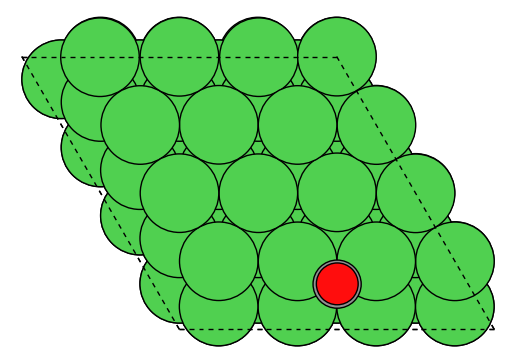

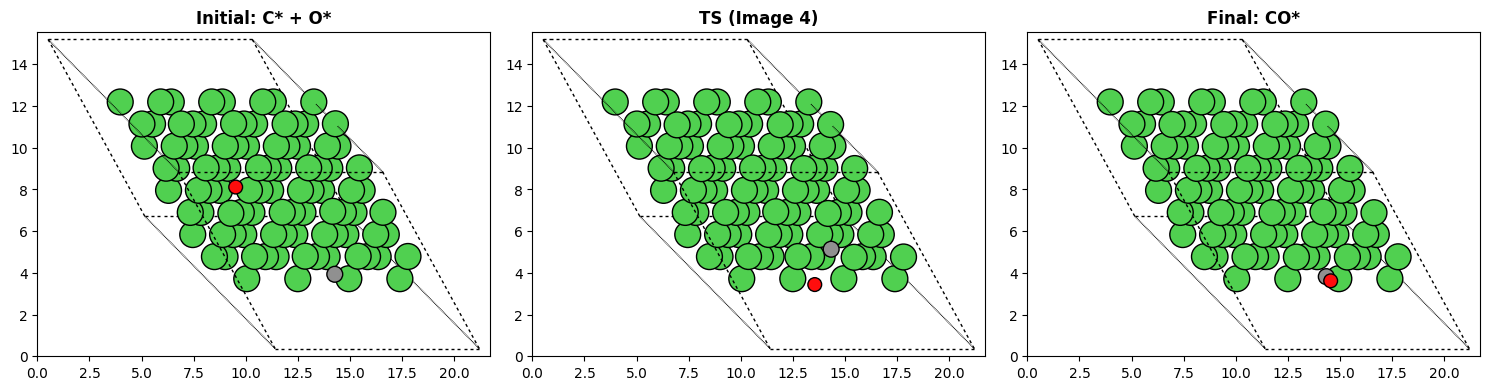


✓ NEB analysis complete!


In [41]:
print("\n   Creating NEB visualization...")

# Plot NEB path
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(len(energies_rel)),
    energies_rel,
    "o-",
    linewidth=2,
    markersize=10,
    color="steelblue",
    label="NEB Path",
)
ax.axhline(0, color="green", linestyle="--", alpha=0.5, label="Initial: C*+O*")
ax.axhline(delta_E_zpe, color="red", linestyle="--", alpha=0.5, label="Final: CO*")
ax.axhline(
    E_barrier,
    color="orange",
    linestyle=":",
    alpha=0.7,
    linewidth=2,
    label=f"Forward Barrier = {E_barrier:.2f} eV",
)

# Annotate transition state
ts_idx = np.argmax(energies_rel)
ax.annotate(
    f"TS\n{energies_rel[ts_idx]:.2f} eV",
    xy=(ts_idx, energies_rel[ts_idx]),
    xytext=(ts_idx, energies_rel[ts_idx] + 0.3),
    ha="center",
    fontsize=11,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", lw=1.5, color="red"),
)

ax.set_xlabel("Image Number", fontsize=13)
ax.set_ylabel("Relative Energy (eV)", fontsize=13)
ax.set_title(
    "CO Formation on Ni(111): C* + O* → CO* - NEB Path", fontsize=15, fontweight="bold"
)
ax.legend(fontsize=11, loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    str(output_dir / part_dirs["part6"] / "neb_path.png"), dpi=300, bbox_inches="tight"
)
plt.show()

# Create animation of NEB path
print("\n   Creating NEB path animation...")
from ase.io import write as ase_write

ase.io.write(
    str(output_dir / part_dirs["part6"] / "neb_path.gif"), images, format="gif"
)
print("   → Saved as neb_path.gif")

# Visualize key structures
print("\n   Visualizing initial state (C* + O*)...")
view(initial_c_o, viewer='x3d')

print("\n   Visualizing transition state...")
view(images[ts_idx], viewer='x3d')

print("\n   Visualizing final state (CO*)...")
view(final_co, viewer='x3d')

print("\n✓ NEB analysis complete!")

```{admonition} Missing UMA access?
:class: dropdown, tip

Don't have access to UMA yet? You can still explore this calculation!

[Download example CO on Ni(111) structure](example_configs/co_on_ni111.xyz) and [Download C+O on Ni(111) structure](example_configs/c_o_on_ni111.xyz) to test in the [UMA demo (no login required)](https://facebook-fairchem-uma-demo.hf.space/) and explore the reaction pathway.
```

```{admonition} Comparison with Paper (Tables 4 & 5)
:class: note

**Expected Results from Paper:**
- **Reaction Energy (C* + O* → CO*)**: **-142.7 kJ/mol = -1.48 eV** (exothermic, DFT-D3)
- **Activation Barrier (C* + O* → CO*)**: **153 kJ/mol = 1.59 eV** (reverse/dissociation, DFT-D3)
- **CO Adsorption Energy**: **1.82 eV = 175.6 kJ/mol** (DFT-D3)

**Reaction Direction:**
- Paper reports CO dissociation barrier (CO* → C* + O*), which is the **reverse** of the recombination we calculate
- Forward (C* + O* → CO*): barrier = reverse_barrier - |ΔE| ≈ 1.59 - 1.48 ≈ 0.11 eV (very fast)
- Reverse (CO* → C* + O*): barrier = 1.59 eV (very slow, kinetic bottleneck)

**What to Check:**
- Reaction energy (C*+O* → CO*) should be strongly exothermic (~-1.5 eV)
- Reverse barrier (CO dissociation) should be substantial (~1.6 eV)
- Forward barrier (recombination) should be very small (~0.1 eV)
- CO binds much more strongly than H (1.82 eV vs 0.60 eV)

**Typical Variations:**
- Reaction energies typically accurate within 0.1-0.2 eV
- Barriers more sensitive: expect ±0.2-0.3 eV variation
- ZPE corrections typically add 0.05-0.15 eV to reaction energies
- NEB convergence affects barrier more than reaction energy

**Physical Insight:**
- Large reverse barrier (1.59 eV) makes CO dissociation very slow at low T
- Small forward barrier (0.11 eV) means C+O rapidly recombine to CO
- This explains why Ni produces CO in Fischer-Tropsch rather than keeping C and O separate
- High temperatures needed to overcome the dissociation barrier for further C-C coupling
```

```{admonition} NEB Method Explained
:class: note

The **Nudged Elastic Band (NEB)** method finds the minimum energy path between reactants and products:

1. **Interpolate** between initial and final states (5-9 images typical)
2. **Add spring forces** along the chain to maintain spacing
3. **Project out** spring components perpendicular to the path
4. **Climbing image** variant: highest energy image climbs to saddle point

Advantages:
- No prior knowledge of transition state needed
- Finds entire reaction coordinate
- Robust for complex reactions

Limitations:
- Computationally expensive (optimize N images)
- May find wrong path if initial interpolation is poor
```

### Explore on Your Own

1. **Image convergence**: Run with 7 or 9 images. Does the barrier change?
2. **Spring constant**: Modify the NEB spring constant. How does this affect convergence?
3. **Alternative paths**: Try different initial CO/final C+O configurations. Are there multiple pathways?
4. **Reverse barrier**: Calculate E_a(reverse) = E_a(forward) - ΔE. Check Brønsted-Evans-Polanyi relationship.
5. **Diffusion barriers**: Compute NEB for C or O diffusion on the surface. How do they compare?

---

## Summary and Best Practices

### Key Takeaways

1. **ML Potentials**: UMa-S-1P1 provides ~1000× speedup over DFT with reasonable accuracy
2. **Bulk optimization**: Always use the ML-optimized lattice constant for consistency
3. **Surface energies**: Linear extrapolation eliminates finite-size effects
4. **Adsorption**: Test multiple sites; lowest energy may not be intuitive
5. **Coverage**: Lateral interactions become significant above ~0.3 ML
6. **Barriers**: NEB requires careful setup but yields full reaction pathway

### Recommended Workflow for New Systems

```{mermaid}
graph TD
    A[Optimize Bulk] --> B[Calculate Surface Energies]
    B --> C[Wulff Construction]
    C --> D[Low-Coverage Adsorption]
    D --> E{Coverage Important?}
    E -->|Yes| F[Coverage Study]
    E -->|No| G[Reaction Barriers]
    F --> G
    G --> H[Microkinetic Modeling]
```

### Accuracy Considerations

| Property | Typical Error | When Critical |
|----------|--------------|---------------|
| Lattice constants | 1-2% | Strain effects, alloys |
| Surface energies | 10-20% | Nanoparticle shapes |
| Adsorption energies | 0.1-0.3 eV | Thermochemistry |
| Barriers | 0.2-0.5 eV | Kinetics, selectivity |

**Rule of thumb**: Use ML for screening → DFT for validation → Experiment for verification

### Further Reading

- **UMA Paper**: [Wood et al. 2025](https://arxiv.org/abs/2506.23971)
- **OMat24 Paper**: [Barroso-Luque et al., 2024](https://arxiv.org/abs/2410.12771)
- **OC20 Dataset**: [Chanussot et al., ACS Catalysis, 2021](https://pubs.acs.org/doi/full/10.1021/acscatal.0c04525)
- **ASE Tutorial**: [https://wiki.fysik.dtu.dk/ase/](https://wiki.fysik.dtu.dk/ase/)
---

## Appendix: Troubleshooting

### Common Issues

**Problem**: Convergence failures
- **Solution**: Reduce `fmax` to 0.1 initially, tighten later
- Check if system is metastable (try different starting geometry)

**Problem**: NEB fails to find transition state
- **Solution**: Use more images (9-11) or better initial guess
- Try fixed-end NEB first, then climbing image

**Problem**: Unexpected adsorption energies
- **Solution**: Visualize structures - check for distortions
- Compare with multiple sites
- Add D3 corrections

**Problem**: Out of memory
- **Solution**: Reduce system size (smaller supercells)
- Use fewer NEB images
- Run on HPC with more RAM

### Performance Tips

1. **Use batching**: Relax multiple configurations in parallel
2. **Start with DEBUG_MAX_STEPS=50**: Get quick results, refine later
3. **Cache bulk energies**: Don't recalculate reference systems
4. **Trajectory analysis**: Monitor optimization progress with ASE GUI

---

## Caveats and Pitfalls

```{admonition} Important Considerations
:class: warning

When using ML potentials for surface catalysis, be aware of these critical issues!
```

### 1. Task Selection: OMAT vs OC20

**Critical choice**: Which task_name to use?
- **`task_name="omat"`**: Optimized for bulk and clean surface calculations
  - Use for: Part 1 (bulk), Part 2 (surface energies), Part 3 (Wulff)
  - Better for structural relaxations without adsorbates
- **`task_name="oc20"`**: Optimized for surface chemistry with adsorbates
  - Use for: Part 4-6 (all adsorbate calculations)
  - Trained on Open Catalyst data with adsorbate-surface interactions

**Impact**: Using wrong task can lead to 0.1-0.3 eV errors in adsorption energies!

### 2. D3 Dispersion Corrections

**Multiple decisions required**:

1. **Whether to use D3 at all?**
   - Small adsorbates (H, O, N): D3 effect ~0.01-0.05 eV (often negligible)
   - Large molecules (CO, CO₂, aromatics): D3 effect ~0.1-0.3 eV (important!)
   - Physisorption: D3 critical (can change binding from repulsive to attractive)
   - RPBE was originally fit for chemisorption energies without D3 corrections, so adding D3 corrections may actually cause small adsorbates to overbind. However, it probably would be important for larger molecules. It's relatively uncommon to see RPBE+D3 as a choice in the catalysis literature (compared to PBE+D3, or RPBE, or BEEF-vdW). 

2. **Which DFT functional for D3?**
   - This tutorial uses `method="PBE"` consistently for the D3 correction. This is often implied when papers say they use a D3 correction, but the results can be different if use the RPBE parameterizations.
   - Original paper used PBE for bulk/surfaces, RPBE for adsorption. It's not specified what D3 parameterization they used, but it's likely PBE. 

3. **When to apply D3?**
   - **End-point correction** (used here): Fast, run ML optimization then add D3 energy
   - **During optimization**: Slower but more accurate geometries
   - **Impact**: Usually <0.05 eV difference, but can be larger for weak interactions

### 3. Coverage Dependence Challenges

**Non-linearity at high coverage**:
- This tutorial assumes linear E_ads(θ) = E₀ + βθ
- Reality: Often non-linear, especially near θ = 1 ML. See the plots generated - there is a linear regime for relatively high coverage, and relatively low coverage, but it's not uniformly linear everywhere. As long as you consistently in one regime or the other a linear assumption is probably ok, but you could get into problems if solving microkinetic models where the coverage of the species in question changes significantly from very low to high. 
- **Why**: Phase transitions, adsorbate ordering, surface reconstruction
- **Solution**: Test polynomial fits, look for ordering in visualizations

**Low coverage limit**:
- At θ < 0.1 ML, coverage effects are tiny (<0.01 eV)
- Hard to distinguish from numerical noise
- **Best practice**: Focus on 0.25-1.0 ML range for fitting

### 4. Periodic Boundary Conditions

**UMa requires PBC=True in all directions!**
```python
atoms.set_pbc([True, True, True])  # Always required
```
- Forgetting this causes crashes or wrong energies
- Even for "gas phase" molecules in vacuum

### 5. Gas Phase Reference Energies

**Tricky cases**:
- **H₂(g)**: UMa handles well (used in this tutorial)
- **H(g)**: May not be reliable (use H₂/2 instead)
- **CO(g)**, **O₂(g)**: Usually okay, but check against DFT
- **Radicals**: Often problematic

**Best practice**: Always use stable molecules as references (H₂, not H; H₂O, not OH)

### 6. Spin Polarization

**Key limitation**: OC20/UMa does not include spin!
- Paper used spin-polarized DFT
- **Impact**: Usually small (0.05-0.1 eV)
- **Larger** for:
  - Magnetic metals (Fe, Co, Ni)
  - Open-shell adsorbates (O*, OH*)
  - Reaction barriers with radicals

### 7. Constraint Philosophy

**Clean slabs** (Part 2): No constraints (both surfaces relax)
- Best for surface energy calculations
- More physical for symmetric slabs

**Adsorbate slabs** (Part 4-6): Bottom layers fixed
- Faster convergence
- Prevents adsorbate-induced reconstruction
- Standard practice in surface chemistry

**Fairchem helper functions**: Automatically apply sensible constraints
- Trust their heuristics unless you have good reason not to
- Check `atoms.constraints` to see what was applied

### 8. Complex Surface Structures

**This tutorial uses low-index facets** (111, 100, 110, 211)
- Well-defined, symmetric
- Easy to generate and analyze

**Real catalysts** have:
- Steps, kinks, grain boundaries
- Support interfaces
- Defects and vacancies
- **Challenge**: Harder to generate, more configurations to test

### 9. Slab Thickness and Vacuum

**Convergence tests critical** but expensive:
- This tutorial uses "reasonable" values (4-8 layers, 10 Å vacuum)
- **Always check** convergence for new systems
- **Especially important** for:
  - Metals with long electron screening (Au, Ag)
  - Charged adsorbates
  - Strong adsorbate-induced reconstruction

### 10. NEB Convergence

**Most computationally expensive part**:
- May need 7-11 images (not just 5)
- Initial guess matters a lot
- Can get stuck in local minima

**Tricks**:
1. Use dimer method to find better TS guess (as shown in Part 6)
2. Start with coarse convergence (fmax=0.2), refine later
3. Visualize the path - does it make chemical sense?
4. Try different spring constants (0.1-1.0 eV/Å)

### 11. Lattice Constant Source

**Consistency is key**:
- Use ML-optimized lattice constant throughout (as done here)
- **Don't mix**: ML lattice + DFT surface energies = inconsistent
- Alternative: Use experimental lattice constant for everything

### 12. Adsorbate Placement

**Multiple local minima**:
- Surface chemistry is **not** convex!
- Always test multiple adsorption sites
- Fairchem helpers generate ~5 configurations in this tutorial, but you may need more to search many modes. You can already try methods like minima hopping or other global optimization methods to sample more configurations.

**For complex adsorbates**:
- Test different orientations
- May need 10-20 configurations
- Consider genetic algorithms or basin hopping

---

```{admonition} Congratulations! 🎉
:class: tip

You've completed a comprehensive computational catalysis workflow using state-of-the-art ML potentials. You can now:

- Characterize catalyst surfaces computationally
- Predict nanoparticle shapes
- Calculate reaction thermodynamics and kinetics
- Apply these methods to your own research questions

**Next steps**: 
- Apply to your catalyst system of interest
- Validate key results with DFT
- Develop microkinetic models
- Publish your findings!
```